# 1 IMPORTS

In [1]:
import os
import sqlalchemy
import dotenv
import random
import pickle
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import scikitplot        as skplt
import lightgbm          as lgb

from scipy.stats           import kurtosis, skew,chi2_contingency
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from xgboost               import XGBClassifier
from sklearn               import svm
from sklearn.neighbors     import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes   import GaussianNB
from imblearn.combine      import SMOTETomek

from sklearn               import linear_model    as lm
from sklearn               import model_selection as ms
from sklearn               import ensemble        as en

from IPython.display import Image

## 1.1 Helper Functions

In [2]:
def jupyter_settings():
    """
    sets up jupyter to prefered settings
    """
        
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.float_format = '{:,.2f}'.format
    pd.options.mode.chained_assignment = None
    
    sns.set()
    
    return None

def postgres_con():
    """
    Connects to mariadb based on .env information
    """
    dotenv.load_dotenv( dotenv.find_dotenv() )
    
    username = os.getenv('USERNAME')
    password = os.getenv('PASSWORD_PA')
    host =     os.getenv('HOST')
    port =     os.getenv('PORT')    
    database = os.getenv('DATABASE')
    
    con = sqlalchemy.create_engine(f'postgresql://{username}:{password}@{host}:{port}/{database}')
    
    return con

def cramer_v( x, y ):
    """
    Calculates the correlation between categorical variables, x and y are pandas series.
    """
    
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


class freq_encoder():
    def fit(self, col: pd.Series):
        map_values = dict( col.groupby(col.columns[0]).size()/len(col) )
        self.map_values = map_values
    
    def transform(self, col) -> pd.Series:
        col = col.copy()
        col[col.columns[0]] = col[col.columns[0]].map( self.map_values )
        return col
    
    def fit_transform(self, col) -> pd.Series:
        self.fit(col)
        return self.transform(col)
    
    
def recall_at_k(x, y, yhat, k=None):
    
    if k is None:
        k = 0.5*len(x)
    
    k=int(k)
    
    yhat = pd.Series(yhat[:,1], name='proba')
    df = pd.concat([x.reset_index(drop=True), y.reset_index(drop=True), yhat], axis=1)
    df = df.sort_values('proba', ascending=False).reset_index(drop=True)
    
    df['recall_at_k'] = df['response'].cumsum() / df['response'].sum()
    
    recall_value = df.loc[(k+1),'recall_at_k']
    
    return recall_value


def precision_at_k(x, y, yhat, k=None):
    
    if k is None:
        k = 0.5*len(x)
    
    k=int(k)
    
    yhat = pd.Series(yhat[:,1], name='proba')
    df = pd.concat([x.reset_index(drop=True), y.reset_index(drop=True), yhat], axis=1)
    df = df.sort_values('proba', ascending=False).reset_index(drop=True)
    
    df['precision_at_k'] = df['response'].cumsum() / k
    
    return df.loc[(k+1),'precision_at_k']

def cross_validation(x_train, y_train, model, model_name, verbosity=True):
    ls_recall=[]
    ls_precision=[]
    
    splitter = ms.StratifiedKFold(n_splits=5, shuffle=True)
    
    cont=1
    
    for train_index, test_index in splitter.split(x_train, y_train):
        if verbosity:
            print(f'{model_name}: {cont}/5')
            cont+=1
        
        cv_train_x = x_train.iloc[train_index]
        cv_train_y = y_train.iloc[train_index]
        cv_test_x  = x_train.iloc[test_index]
        cv_test_y  = y_train.iloc[test_index]

        model_ = model.fit(cv_train_x.values, cv_train_y.values)
        yhat = model_.predict_proba(cv_test_x.values)

        recall_model = recall_at_k(cv_test_x, cv_test_y, yhat, k=0.262*len(cv_test_x))
        precision_model = precision_at_k(cv_test_x, cv_test_y, yhat, k=0.262*len(cv_test_x))

        ls_recall.append(recall_model)
        ls_precision.append(precision_model)

    
    return pd.DataFrame({'model_name':model_name,
                        'recall_at_k':f'{np.mean(ls_recall):.4f} +/- {np.std(ls_recall):.4f}',
                        'precision_at_k':f'{np.mean(ls_precision):.4f} +/- {np.std(ls_precision):.4f}'
                       }, index=[0])

In [3]:
jupyter_settings()

## 1.2 Loading data

In [18]:
# with open('../queries/query_fulltable.sql', 'r') as f:
#     query = f.read()
    
# df_raw = pd.read_sql(query, postgres_con())

# #I will save in csv to prevent from occupying the database everytime I work on the project
# df_raw.to_csv('../data/data_all_clients.csv', index=False)

In [4]:
df_raw = pd.read_csv('../data/data_all_clients.csv')

# 2 DATA DESCRIPTION

## 2.1 Rename Columns

In [5]:
#Not necessary, already in snakecase
df_raw.columns

Index(['id', 'previously_insured', 'annual_premium', 'vintage', 'response',
       'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage'],
      dtype='object')

## 2.2 Data Dimensions

In [6]:
print('# of rows:',df_raw.shape[0])
print('# of unique clients:', len(df_raw['id'].unique()))
print('# of columns:',df_raw.shape[1])

# of rows: 381109
# of unique clients: 381109
# of columns: 12


## 2.3 Data Types

In [7]:
df_raw.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 2.4 Check NA

In [8]:
df_raw.isna().sum()

id                      0
previously_insured      0
annual_premium          0
vintage                 0
response                0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 2.5 Fillout NA

In [15]:
#No NA's founds

## 2.6 Change Data Types

In [16]:
#Data types are according to what's desired.

## 2.7 Descriptive Statistics

In [9]:
num_attributes = df_raw.select_dtypes(include= ['int64', 'float64'])
cat_attributes = df_raw.select_dtypes(exclude= ['int64', 'float64'])

### 2.7.1 Numerical Atributes

In [10]:
d1 = np.mean(num_attributes)
d2 = pd.Series(np.median(num_attributes, axis=0), index=d1.index)
d3 = np.std(num_attributes)
d4 = np.min(num_attributes)
d5 = np.max(num_attributes)
d6 = d5-d4
d7 = pd.Series( skew(num_attributes), index= d1.index)
d8 = pd.Series( kurtosis(num_attributes), index= d1.index)

df_description = pd.concat([d1, d2, d3, d4, d5, d6, d7, d8], axis=1)
df_description.columns = ['mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']
df_description

,mean,median,std,min,max,range,skew,kurtosis
id,"190,555.00","190,555.00","110,016.69",1.00,"381,109.00","381,108.00",0.00,-1.20
previously_insured,0.46,0.00,0.50,0.00,1.00,1.00,0.17,-1.97
annual_premium,"30,564.39","31,669.00","17,213.13","2,630.00","540,165.00","537,535.00",1.77,34.00
vintage,154.35,154.00,83.67,10.00,299.00,289.00,0.00,-1.20
response,0.12,0.00,0.33,0.00,1.00,1.00,2.30,3.30
age,38.82,36.00,15.51,20.00,85.00,65.00,0.67,-0.57
region_code,26.39,28.00,13.23,0.00,52.00,52.00,-0.12,-0.87
policy_sales_channel,112.03,133.00,54.20,1.00,163.00,162.00,-0.90,-0.97
driving_license,1.00,1.00,0.05,0.00,1.00,1.00,-21.60,464.35


### 2.7.2 Categorical Atributes

In [11]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

<AxesSubplot:xlabel='gender', ylabel='response'>

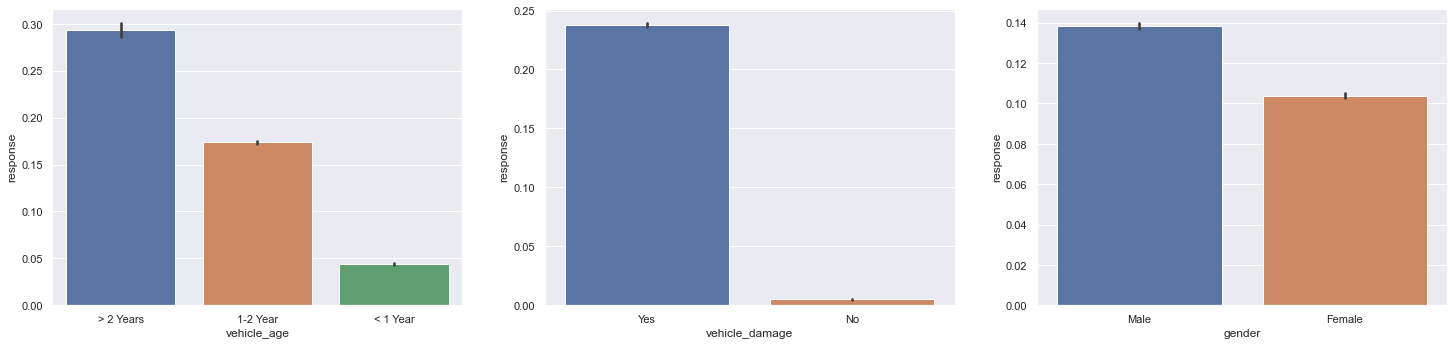

In [12]:
plt.subplot(2,3,1)
sns.barplot(x='vehicle_age',y='response',data=df_raw)

plt.subplot(2,3,2)
sns.barplot(x='vehicle_damage',y='response',data=df_raw)

plt.subplot(2,3,3)
sns.barplot(x='gender',y='response',data=df_raw)

# 3 FEATURE ENGINEERING

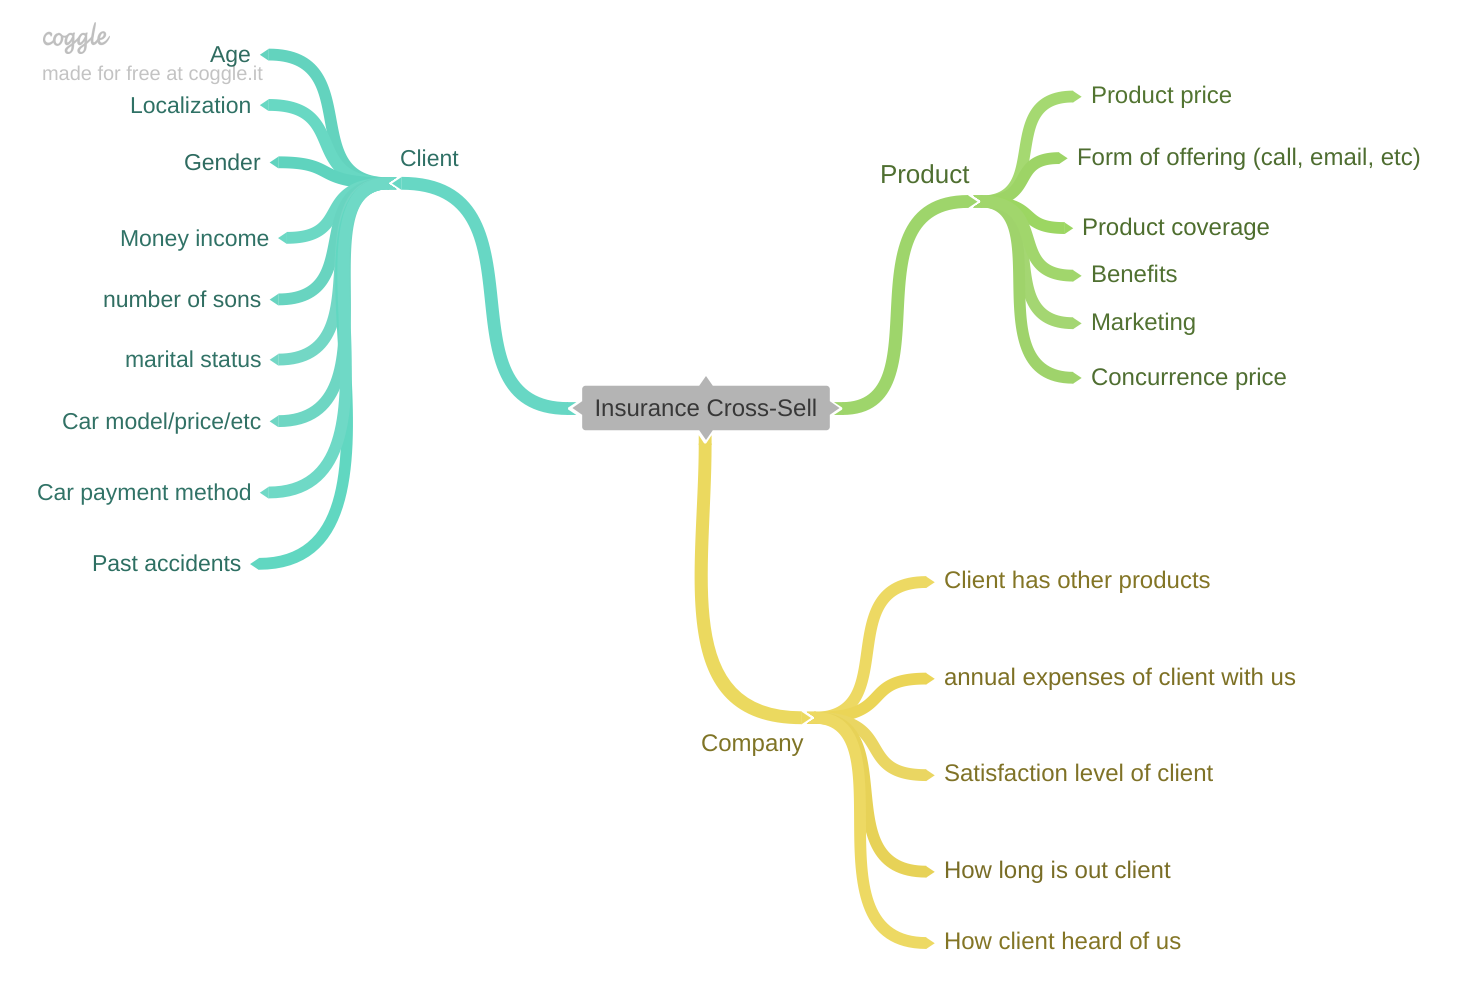

In [30]:
Image('../image/Insurance_Cross-Sell.png')

## 3.1 Business Hypothesis

In [31]:
df_raw

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,1,0,"40,454.00",217,1,Male,44,28.00,26.00,1,> 2 Years,Yes
1,2,0,"33,536.00",183,0,Male,76,3.00,26.00,1,1-2 Year,No
2,3,0,"38,294.00",27,1,Male,47,28.00,26.00,1,> 2 Years,Yes
3,4,1,"28,619.00",203,0,Male,21,11.00,152.00,1,< 1 Year,No
4,5,1,"27,496.00",39,0,Female,29,41.00,152.00,1,< 1 Year,No
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,"30,170.00",88,0,Male,74,26.00,26.00,1,1-2 Year,No
381105,381106,1,"40,016.00",131,0,Male,30,37.00,152.00,1,< 1 Year,No
381106,381107,1,"35,118.00",161,0,Male,21,30.00,160.00,1,< 1 Year,No
381107,381108,0,"44,617.00",74,0,Female,68,14.00,124.00,1,> 2 Years,Yes


I will answer the following hypothesis, since they are what I have enough information for answering:

- Customers with vehicle insurance should be less likely to get want our product;
- There should be few policy sales channel that works really well;
- Older people should want more insurance;
- Older clients should accept more the new insurance;
- People without drivers license should not want insurance at all.
- Lower annual premium prices should increase the chance of selling the new product.
- Females should want less insurance than male clients;
- People with older vehicles should want the insurance more.

## 3.2 Feature Engineering

The data set I am working with is very straightforward in this sense, few information can be derived from tha data. For this reason, no new features will be engineered.

# 4 VARIABLES FILTERING

## 4.1 Rows Filter


There is no client that I need to remove from my base for now. (Check section <b> 6 - DATA PREPARATION </b> for data balance)

## 4.2 Columns Selection

The columns in the current dataset don't lead to any data leakage apparently. So no columns will be filtered out.

# 5 EXPLORATORY DATA ANALYSIS

In [13]:
df5 = df_raw.copy()

In [22]:
df5

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,1,0,"40,454.00",217,1,Male,44,28.00,26.00,1,> 2 Years,Yes
1,2,0,"33,536.00",183,0,Male,76,3.00,26.00,1,1-2 Year,No
2,3,0,"38,294.00",27,1,Male,47,28.00,26.00,1,> 2 Years,Yes
3,4,1,"28,619.00",203,0,Male,21,11.00,152.00,1,< 1 Year,No
4,5,1,"27,496.00",39,0,Female,29,41.00,152.00,1,< 1 Year,No
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,"30,170.00",88,0,Male,74,26.00,26.00,1,1-2 Year,No
381105,381106,1,"40,016.00",131,0,Male,30,37.00,152.00,1,< 1 Year,No
381106,381107,1,"35,118.00",161,0,Male,21,30.00,160.00,1,< 1 Year,No
381107,381108,0,"44,617.00",74,0,Female,68,14.00,124.00,1,> 2 Years,Yes


## 5.1 Univariate Analysis

### 5.1.1 Response Variable

<AxesSubplot:xlabel='response', ylabel='count'>

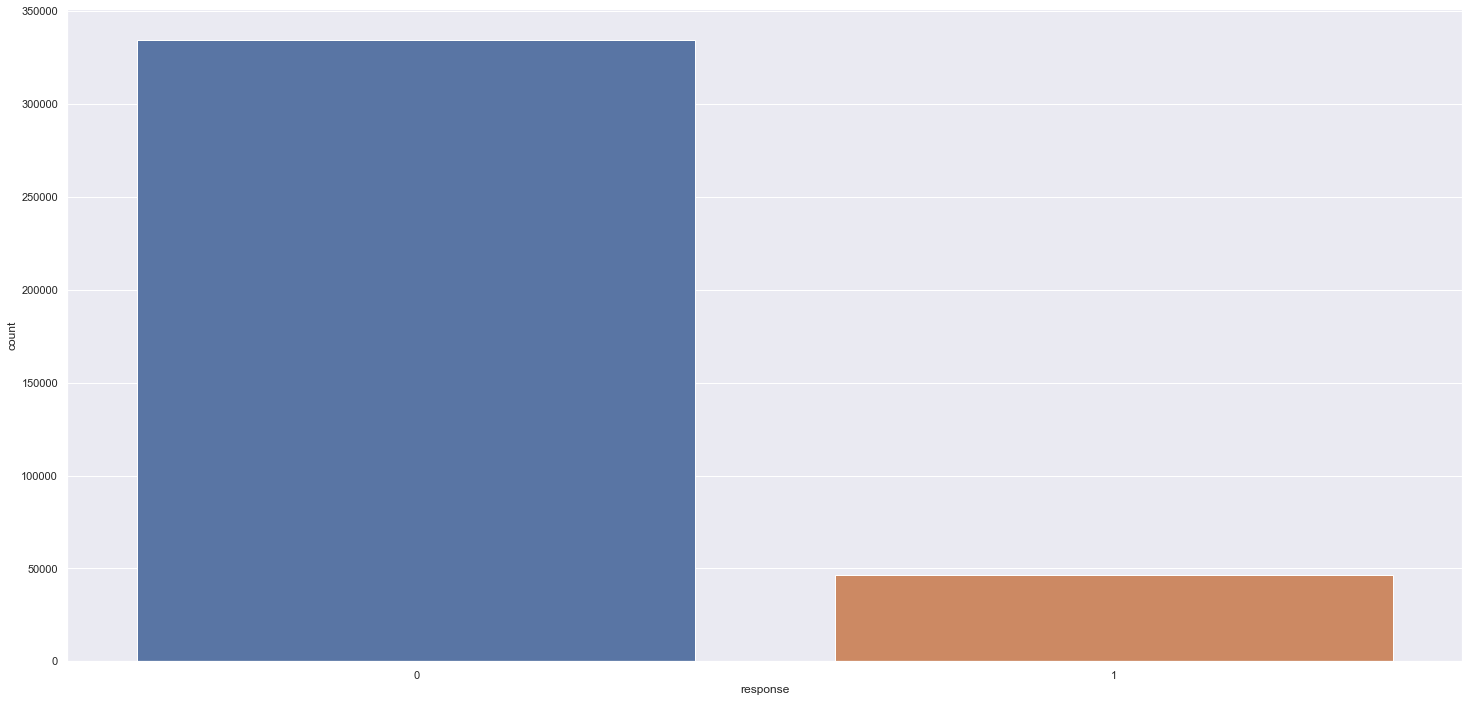

In [23]:
#very unbalanced data, however I could construct a imbalanced model by now and evaluate the need for improvement later


sns.countplot(x='response', data=df5)

### 5.1.2 Numerical Variable

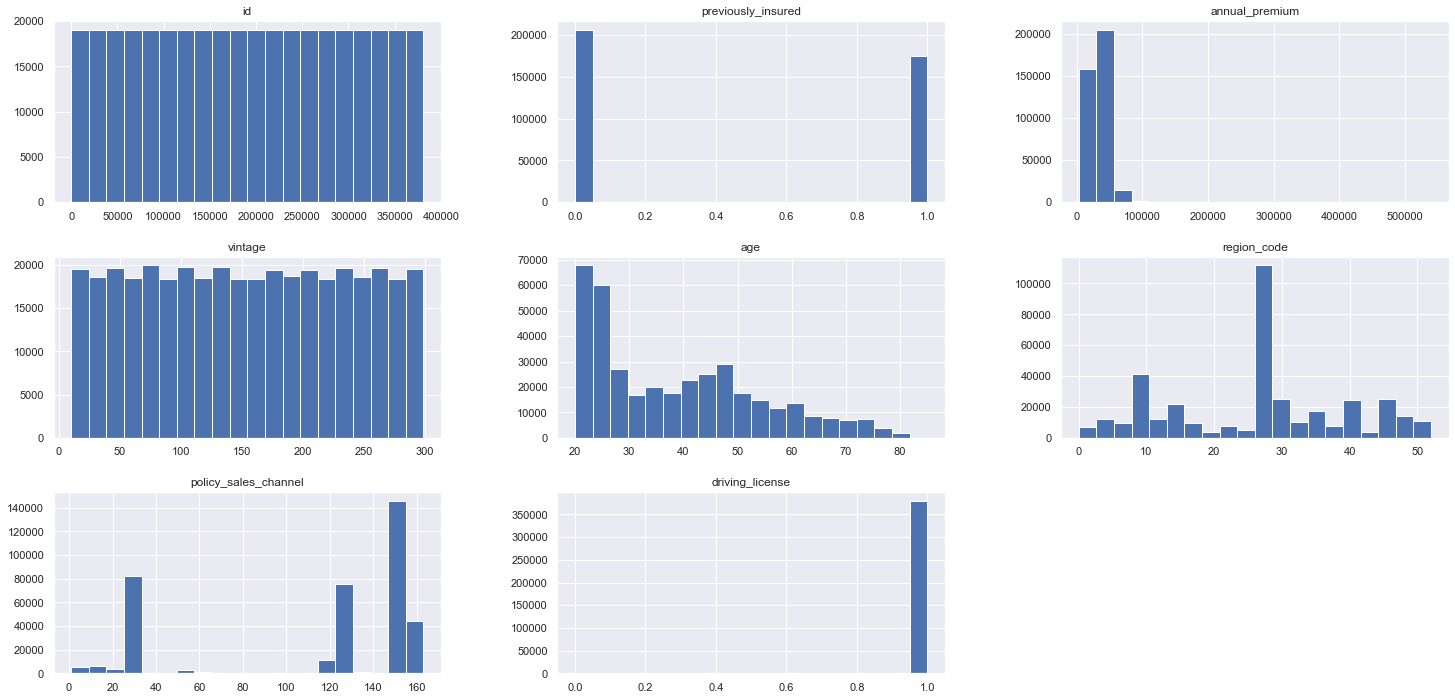

In [24]:
num_attributes = df5.select_dtypes(include=['float64', 'int64']).drop(columns='response')

num_attributes.hist(bins=20);

### 5.1.3 Categorical Variable

In [25]:
cat_attributes = df5[['response','gender', 'vehicle_age', 'vehicle_damage']]

<AxesSubplot:xlabel='vehicle_damage', ylabel='count'>

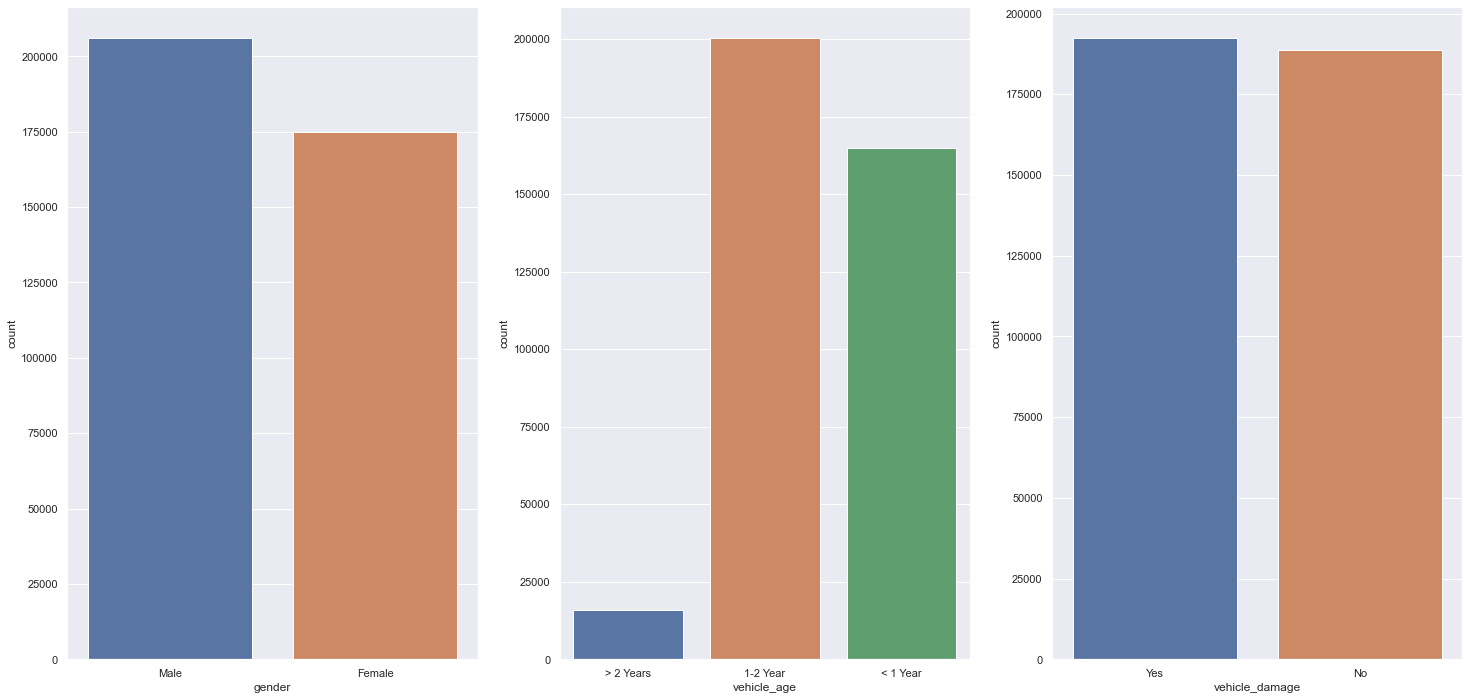

In [26]:
plt.subplot(1,3,1)
sns.countplot(x='gender', data=cat_attributes )

plt.subplot(1,3,2)
sns.countplot(x='vehicle_age', data=cat_attributes )

plt.subplot(1,3,3)
sns.countplot(x='vehicle_damage', data=cat_attributes )

## 5.2 Bivariate Analysis

### Customers with vehicle insurance should be less likely to want our product;
<b>TRUE:</b> Very rarely customers with insurance accept the new one. 

In [27]:
df5[['previously_insured', 'response']].groupby('previously_insured').sum().reset_index()

,previously_insured,response
0,0,46552
1,1,158


<AxesSubplot:xlabel='previously_insured', ylabel='response'>

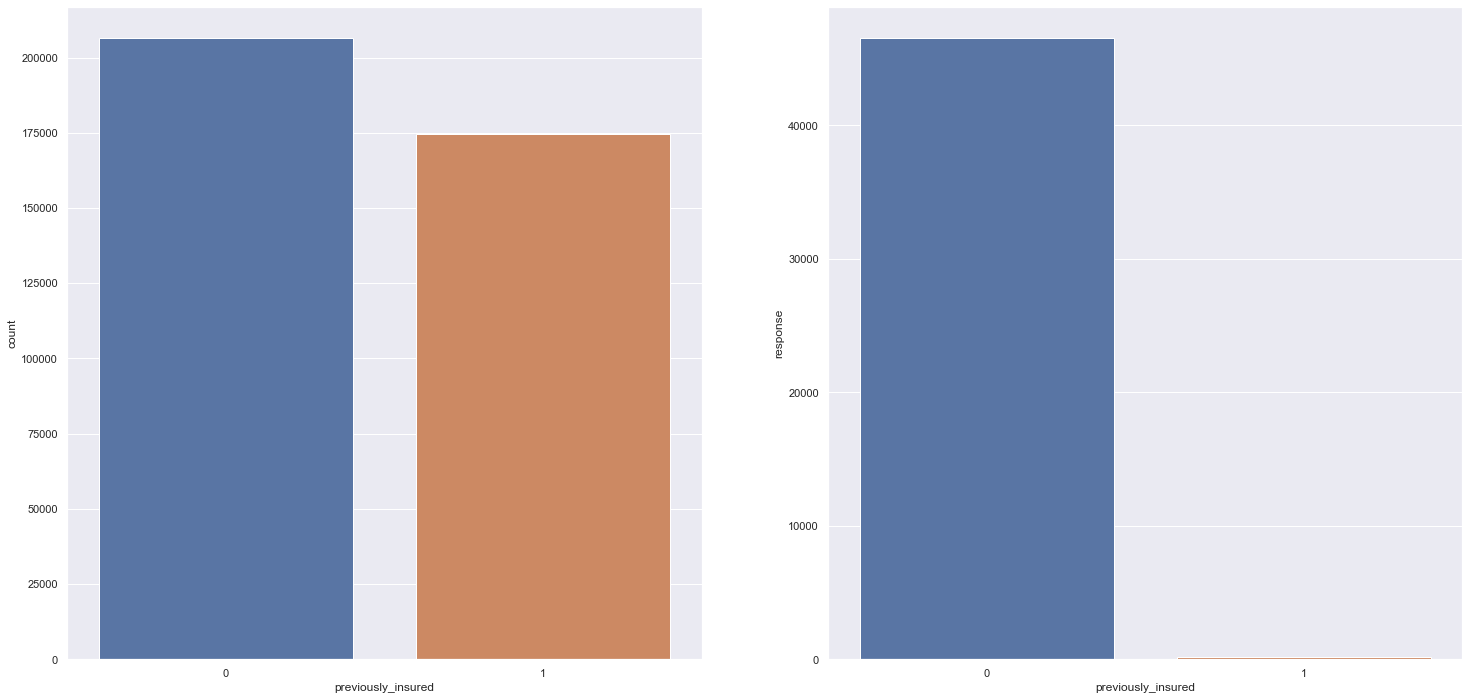

In [28]:
plt.subplot(1,2,1)
sns.countplot(x='previously_insured',data=df5)

plt.subplot(1,2,2)
sns.barplot(x='previously_insured', y='response',data=df5[['previously_insured', 'response']].groupby('previously_insured').sum().reset_index())

Even though there is a good distribution between previously insured and not previously insured, the ones who already had insurance almost never pick the new producct.

### There should be few policy sales channel that works really well;
<b>TRUE:</b> Methods 26 and 124 are responsible for 2/3 of acquisitions. But the rate of a significative amount of methods is around 20% conversion.

<AxesSubplot:xlabel='policy_sales_channel', ylabel='response'>

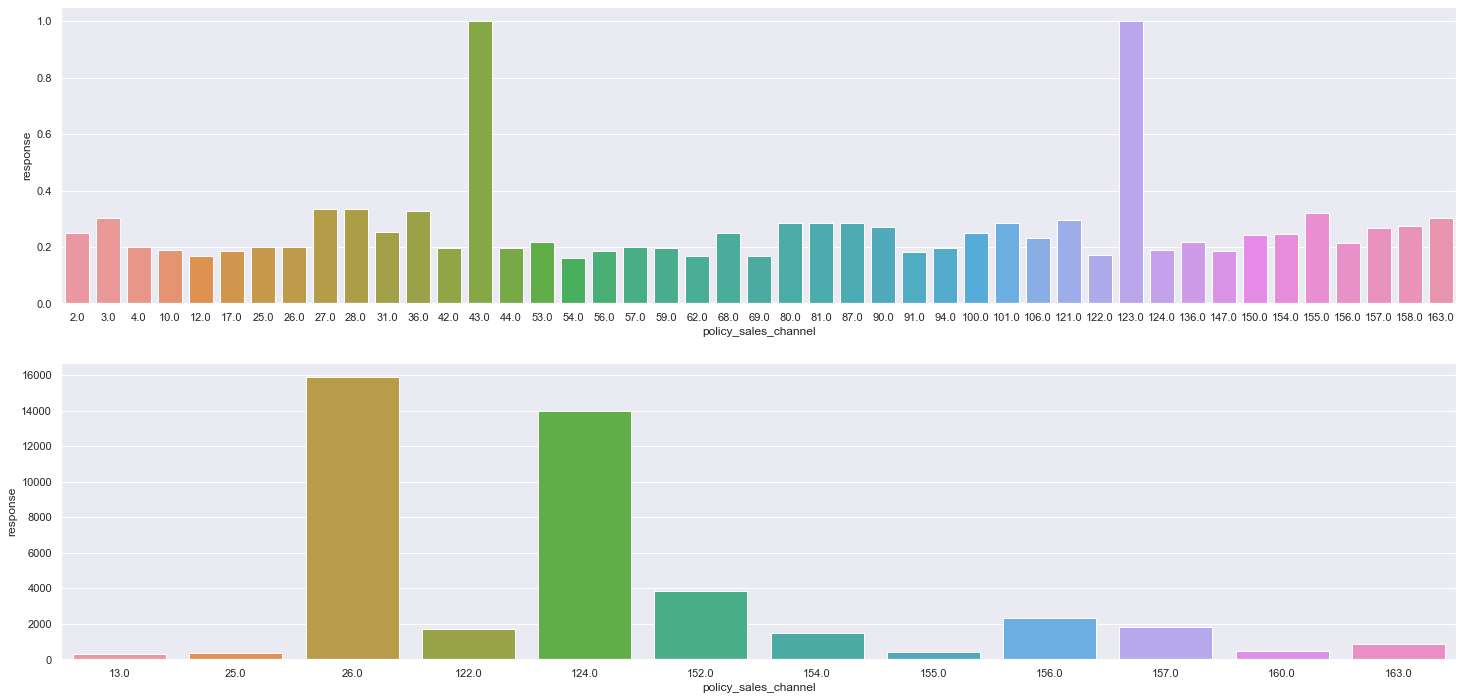

In [29]:
aux1 = df5[['policy_sales_channel', 'response']].groupby('policy_sales_channel').mean().reset_index()
aux2 = df5[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()

aux1 = aux1[aux1['response'] > 0.15]
aux2 = aux2[aux2['response'] > 200]

plt.subplot(2,1,1)
sns.barplot(x='policy_sales_channel',y='response',data=aux1)

plt.subplot(2,1,2)
sns.barplot(x='policy_sales_channel',y='response',data=aux2)

#We disconsider the importance of the outliars because they are represented by only of sample

### Older people should want more insurance;
<b>FALSE:</b> The peak of desire for insurance is in the range of 30 to 50 years

<AxesSubplot:xlabel='age', ylabel='response'>

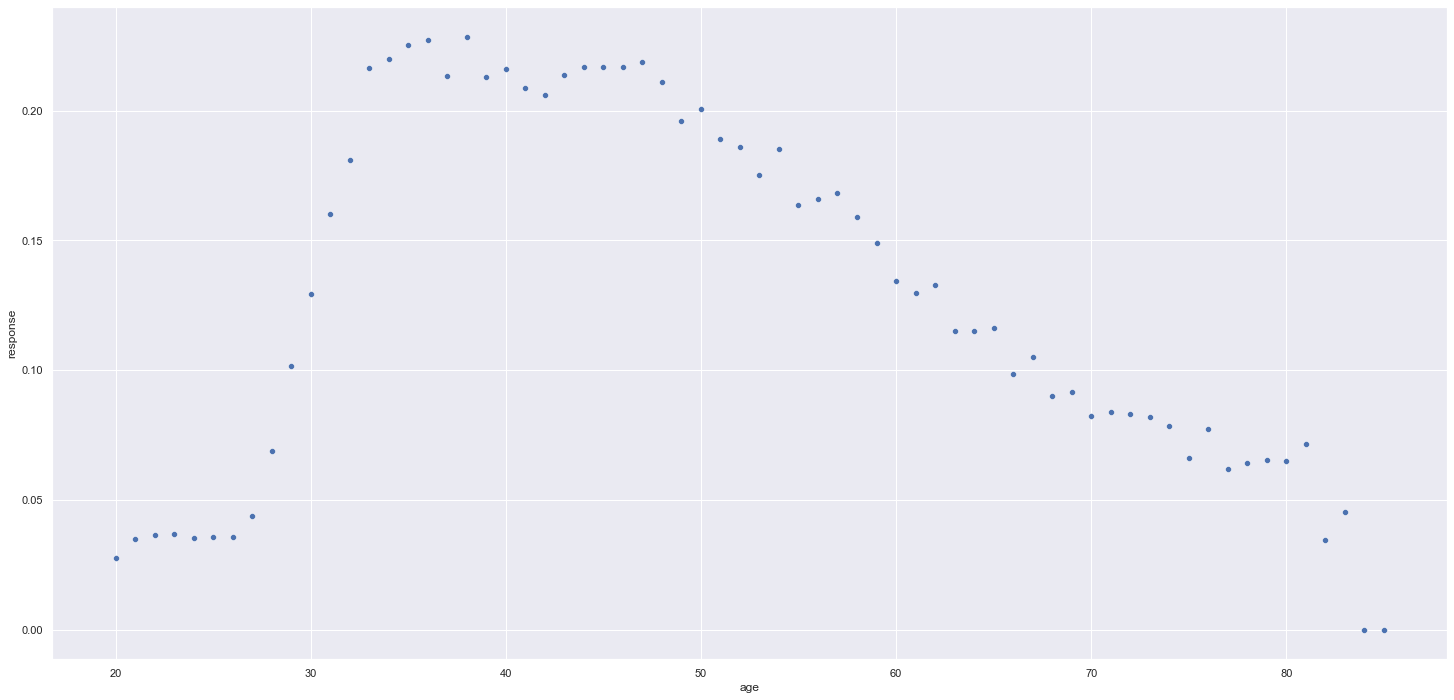

In [30]:
aux1 = df5[['age', 'response']].groupby('age').mean().reset_index()

sns.scatterplot(x='age',y='response',data=aux1)

### People without drivers license should not want insurance at all.
<b>FALSE:</b> The chance of someone not wanting the insurance is divided by ~half when the person doesn't have driving license.

<AxesSubplot:xlabel='driving_license', ylabel='response'>

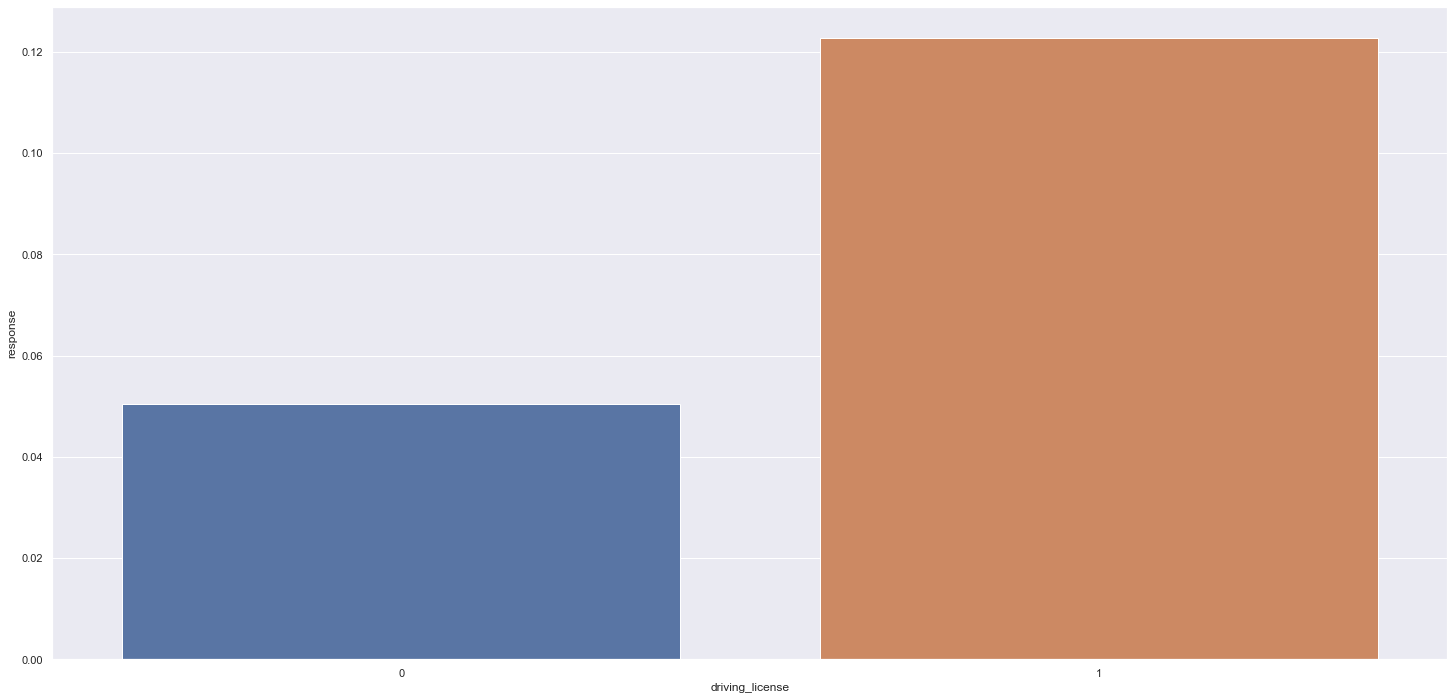

In [31]:
sns.barplot(x='driving_license', y='response',data=df5[['driving_license','response']].groupby('driving_license').mean().reset_index())

### Lower annual premium prices should increase the chance of selling the new product.
<b>FALSE:</b> After about 30,000 annual premium, the aderence is pretty even among prices,

<AxesSubplot:xlabel='annual_premium_binned', ylabel='response'>

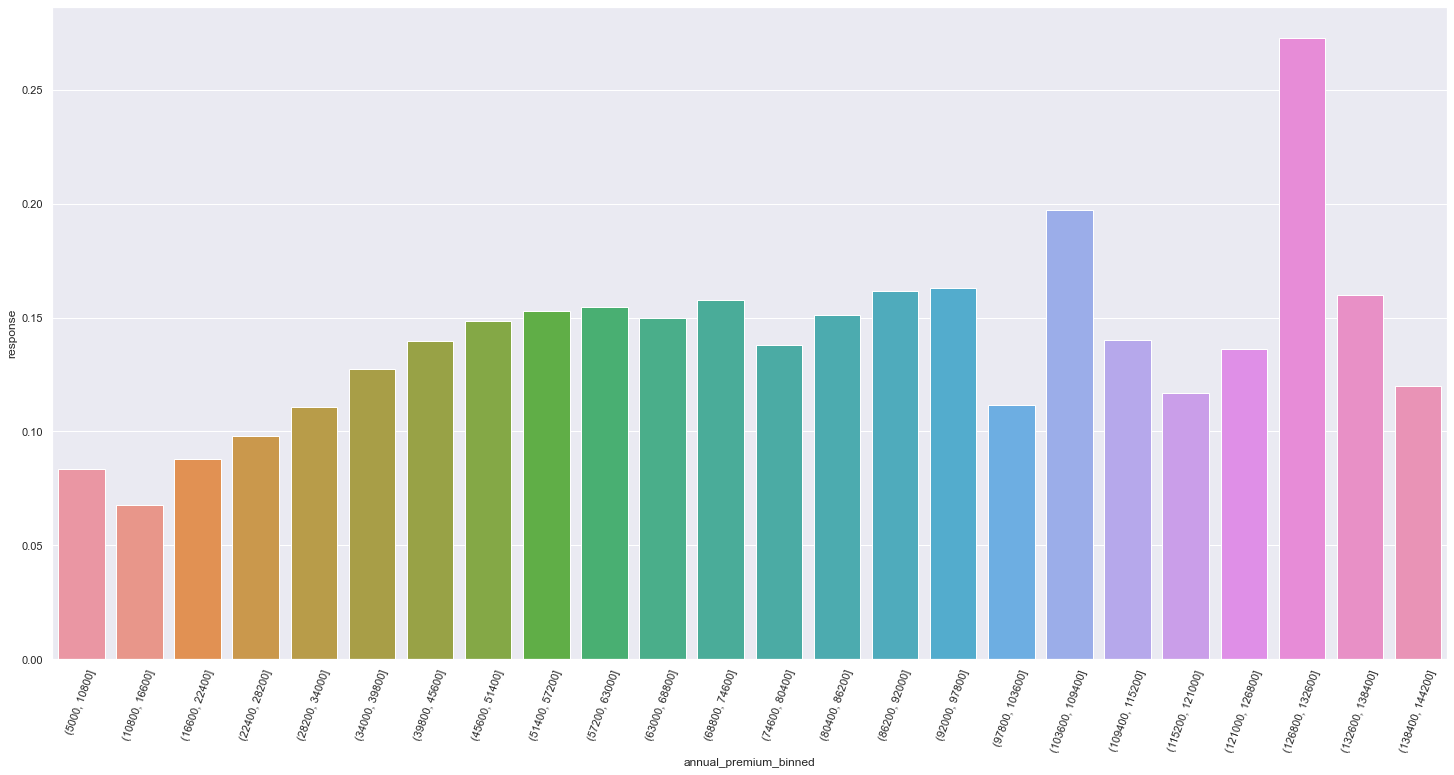

In [32]:
bins = list( np.arange(5000,150000, int((150000-5000)/25) ) )
aux1 = df5[['annual_premium', 'response']].copy()
aux1['annual_premium_binned'] = pd.cut( aux1['annual_premium'], bins=bins )
aux1 = aux1.groupby('annual_premium_binned').mean().reset_index() # using sum because there are few samples in higher values of annual_premium
plt.xticks(rotation=70)

sns.barplot(x='annual_premium_binned',y='response',data=aux1)

### Females should want less insurance than male clients;
<b>TRUE:</b> Men buy more insurance than women.

<AxesSubplot:xlabel='gender', ylabel='response'>

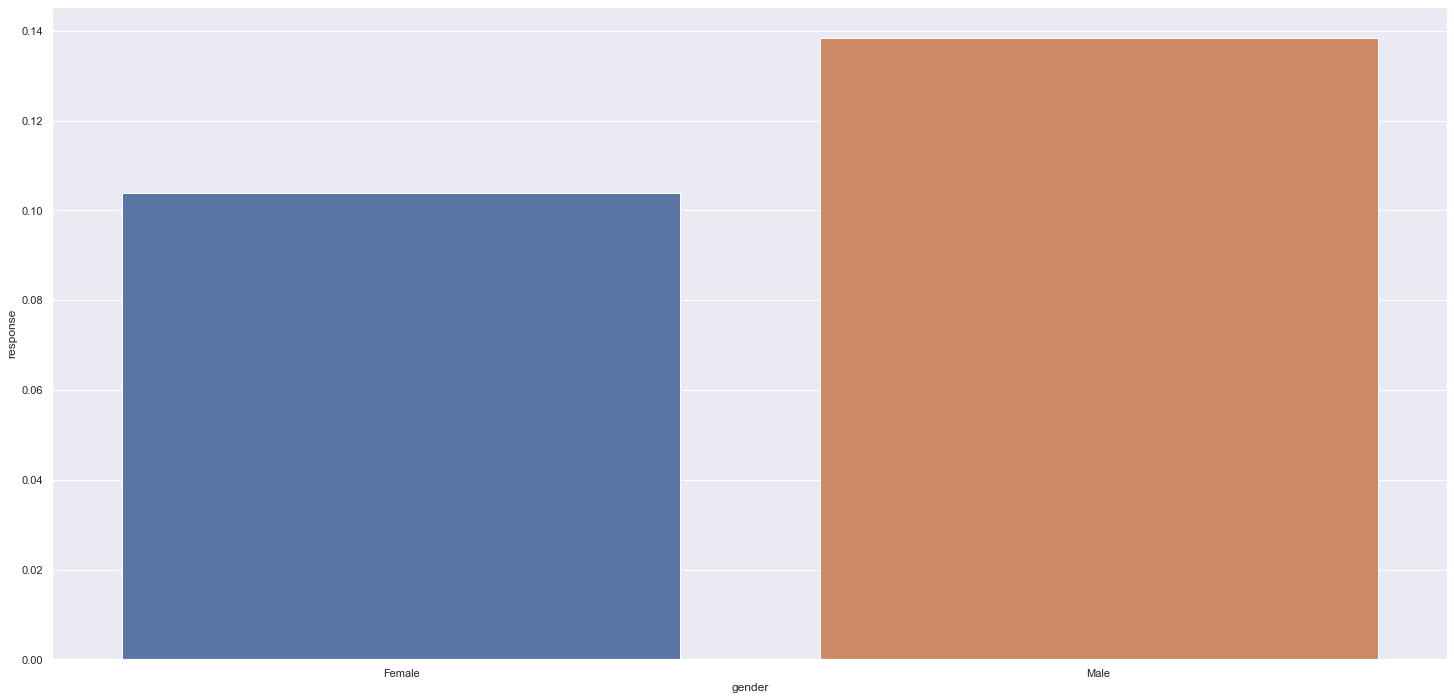

In [33]:
aux1 = df5[['gender','response']].groupby('gender').mean().reset_index()

sns.barplot(x='gender', y='response',data=aux1)

### People with older vehicles should want the insurance more.
<b>True:</b> Older cars imply more insurance buy

<AxesSubplot:xlabel='vehicle_age', ylabel='response'>

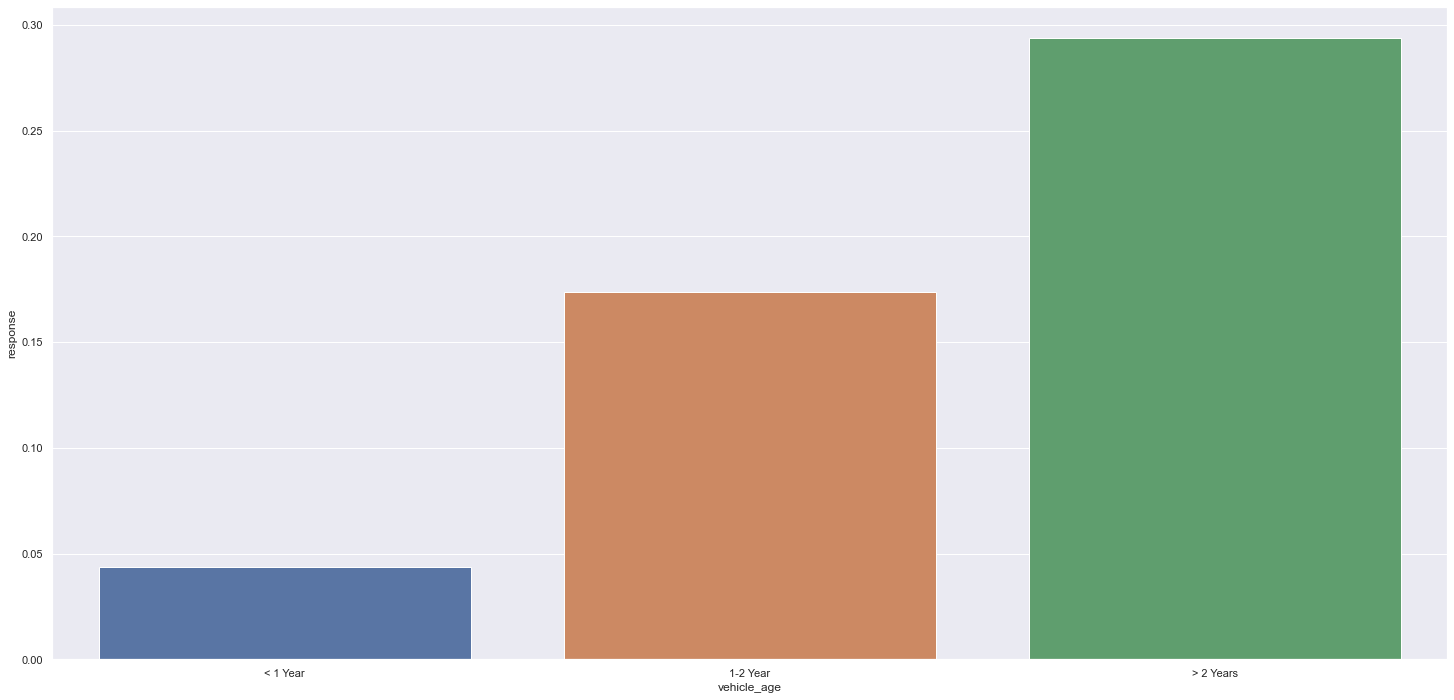

In [34]:
aux1 = df5[['vehicle_age','response']].groupby('vehicle_age').mean().reset_index()
aux1['vehicle_age'] = pd.Categorical(aux1['vehicle_age'], categories=['< 1 Year','1-2 Year', '> 2 Years' ], ordered=True)

sns.barplot(x='vehicle_age',y='response',data=aux1)

### There are certain regions that are more likely to buy our insurance
<b>TRUE:</b> More than half of our buyers come from one single region. 

<AxesSubplot:xlabel='region_code', ylabel='response'>

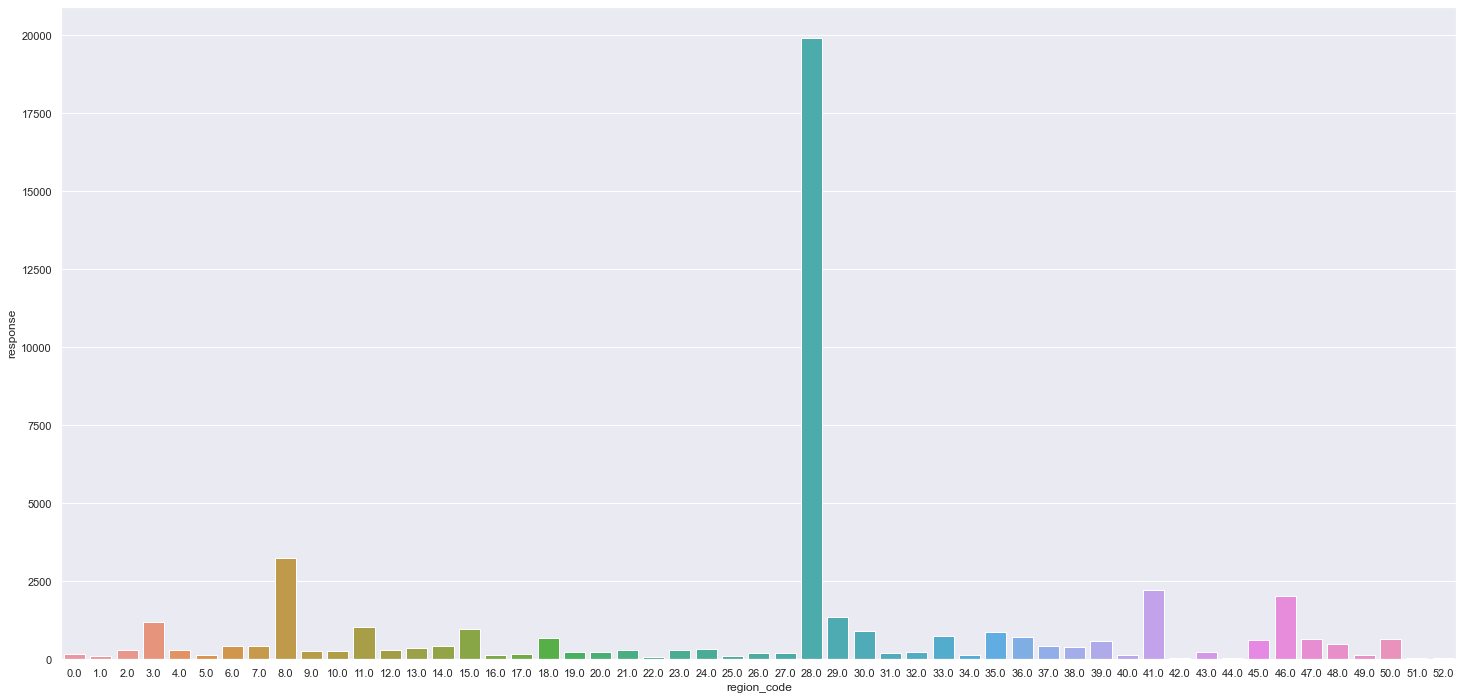

In [35]:
aux1 = df5[['response', 'region_code']].groupby('region_code').sum().reset_index()

sns.barplot(x='region_code',y='response',data=aux1)

<AxesSubplot:xlabel='region_code', ylabel='response'>

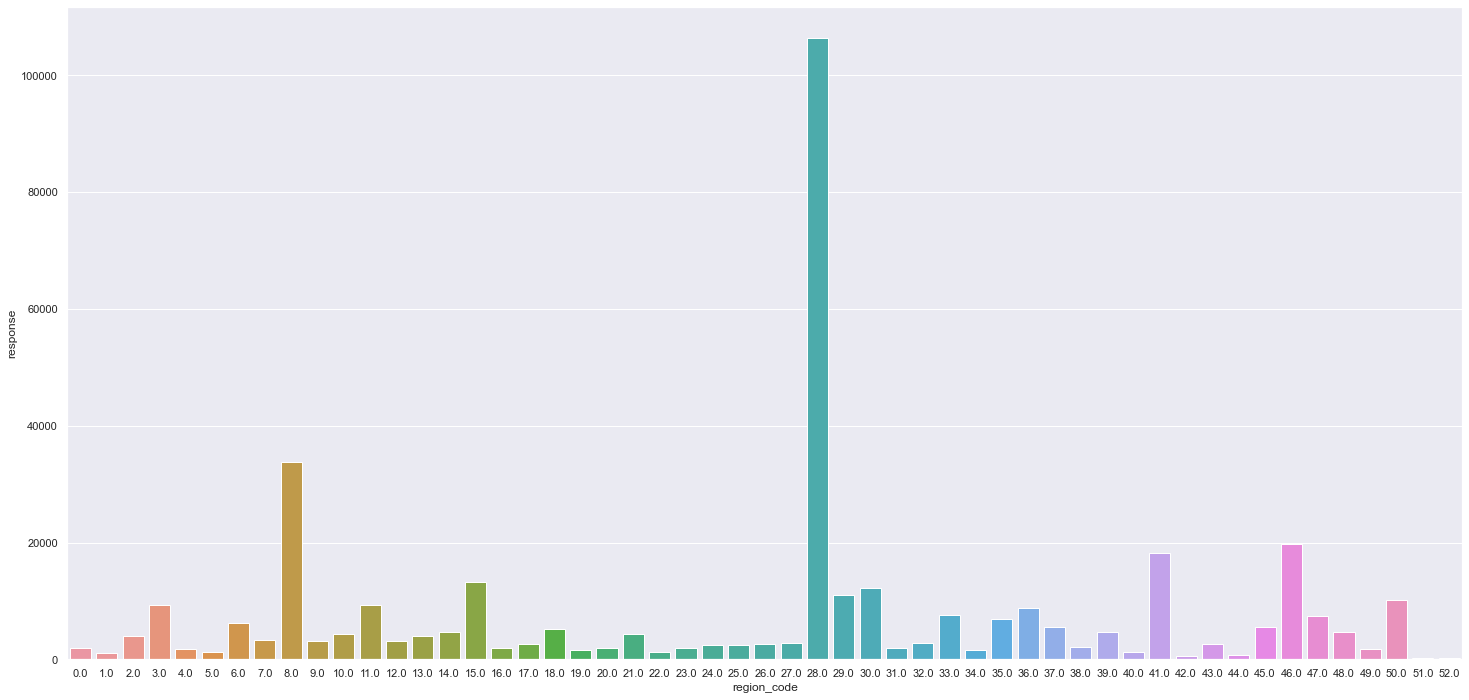

In [36]:
sns.barplot(x='region_code',y='response', data=df5[['response', 'region_code']].groupby('region_code').count().reset_index())

## 5.3 Multivariate Analysis

### 5.3.1 Numerical Attributes

<AxesSubplot:>

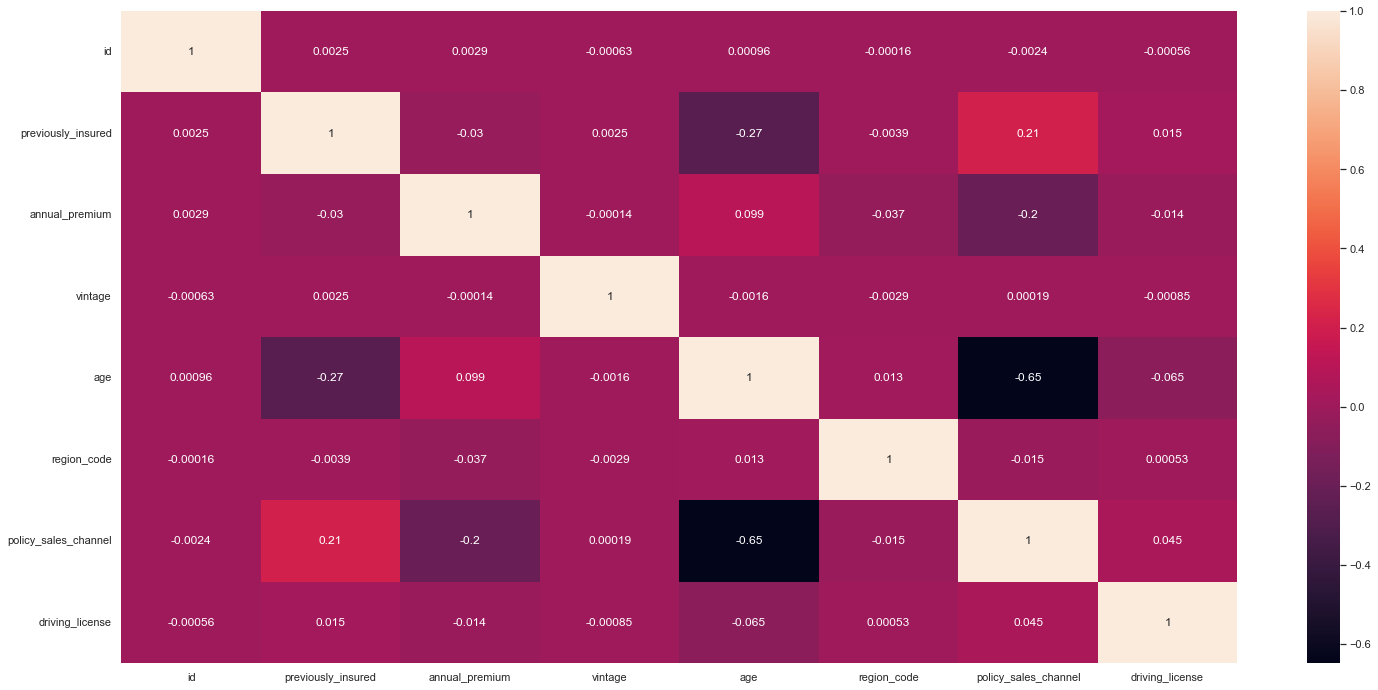

In [37]:
sns.heatmap(num_attributes.corr(method='spearman'), annot=True)

### 5.3.2 Categorical Attributes

<AxesSubplot:>

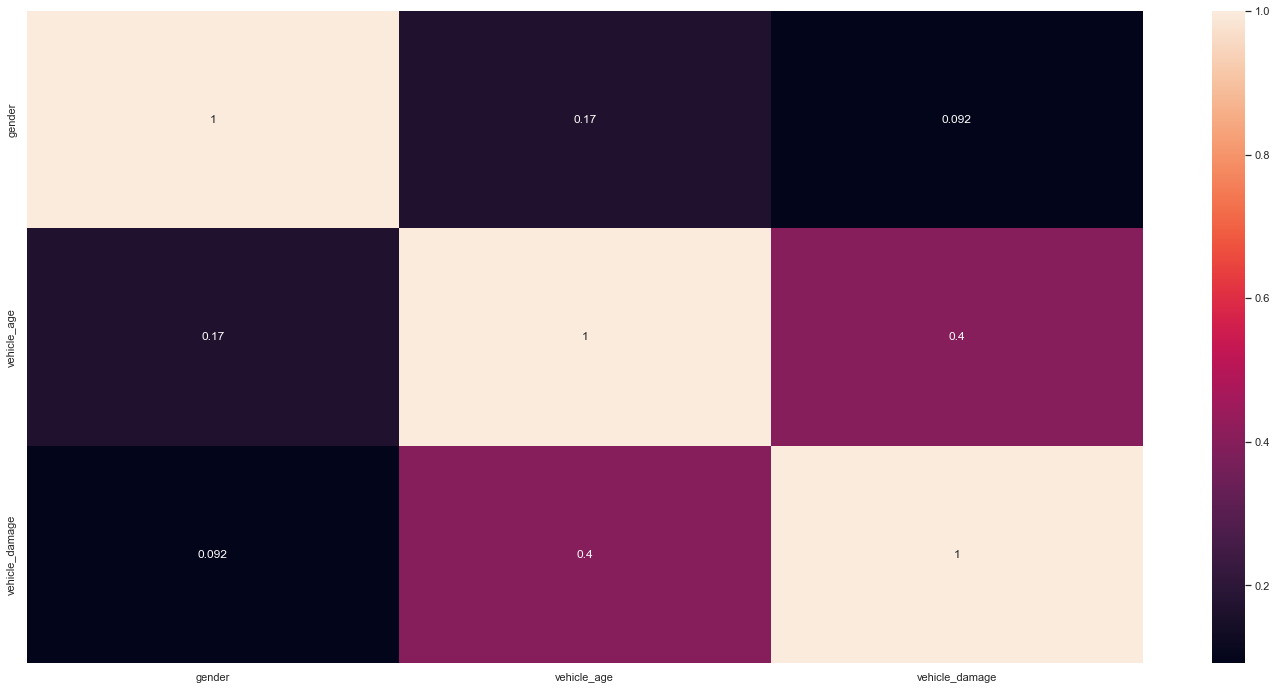

In [38]:
cat_columns = cat_attributes.drop(columns='response').columns

cat_heatmap_dict = {}

for col1 in cat_columns:
    cat_heatmap_dict[col1] = []
    for col2 in cat_columns:
        corr_value = cramer_v(cat_attributes[col1], cat_attributes[col2] )
        cat_heatmap_dict[col1].append(corr_value)
        
cat_corr_heatmap_df = pd.DataFrame(cat_heatmap_dict)
cat_corr_heatmap_df = cat_corr_heatmap_df.set_index( cat_corr_heatmap_df.columns )

sns.heatmap(cat_corr_heatmap_df, annot=True)

# 6 DATA PREPARATION

In [14]:
df6 = df5.drop(columns='id').copy()

X = df6.drop(columns='response').copy()
y = df6['response'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

## 6.1 Normalization

No variables are normally distributed, therefore no normalization will be done

## 6.2 Rescaling

<AxesSubplot:ylabel='age'>

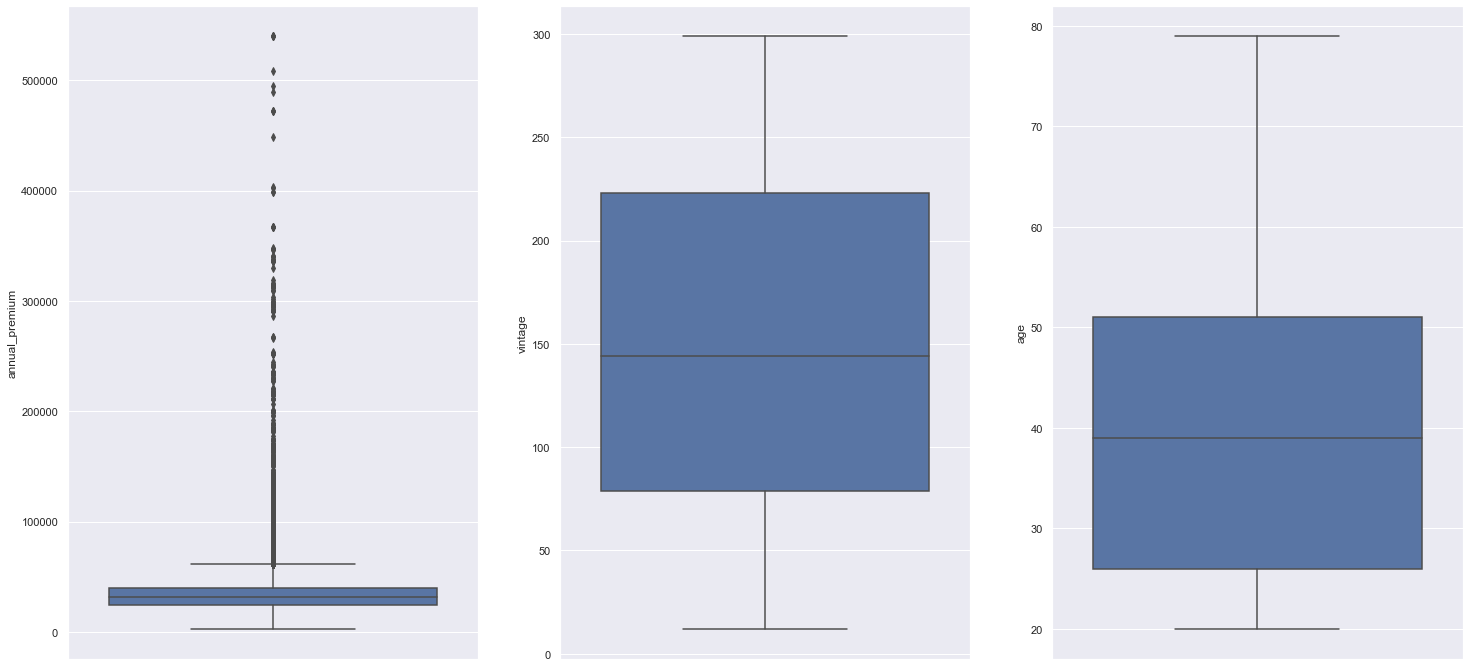

In [40]:
plt.subplot(1,3,1)

sns.boxplot(y=df6['annual_premium'], data=df6['annual_premium']) #Only annual premium needs robust scaler, due to outliers

plt.subplot(1,3,2)

sns.boxplot(y=df6['vintage'], data=df6['vintage'])

plt.subplot(1,3,3)

sns.boxplot(y=df6['age'], data=df6['age'])

In [15]:
# rs = RobustScaler()
# mms = MinMaxScaler()

annual_premium_scaler = RobustScaler()
x_train['annual_premium'] = annual_premium_scaler.fit_transform( x_train[['annual_premium']] )
x_test['annual_premium']  = annual_premium_scaler.transform(x_test[['annual_premium']])

vintage_scaler = MinMaxScaler()
x_train['vintage'] = vintage_scaler.fit_transform( x_train[['vintage']] )
x_test['vintage'] = vintage_scaler.transform( x_test[['vintage']] )

age_scaler = MinMaxScaler()
x_train['age'] = age_scaler.fit_transform( x_train[['age']] )
x_test['age'] = age_scaler.transform( x_test[['age']] )

## 6.3 Transformation

### 6.3.1 Encoding

In [16]:
#Those are the features that need encoding:
# 'gender' -> binary encoding (because only two values)
# 'vehicle_damage' -> binary encoding (because only two values)
# 'vehicle_age' -> label encoder (there is a meaning of progression)
# 'region_code' -> frequency encoding (There are regions that have much more clients, it could be represented by a frequency encoding)
# 'policy_sales_channel' -> frequency encoding(There are policies that reach  many more clients)

#gender
x_train['gender'] = x_train[['gender']].apply(lambda x: 1 if x['gender'] == 'Female' else 0, axis=1)
x_test['gender'] = x_test[['gender']].apply(lambda x: 1 if x['gender'] == 'Female' else 0, axis=1)

#vehicle_damage
x_train['vehicle_damage'] = x_train[['vehicle_damage']].apply(lambda x: 1 if x['vehicle_damage'] == 'Yes' else 0, axis=1)
x_test['vehicle_damage'] = x_test[['vehicle_damage']].apply(lambda x: 1 if x['vehicle_damage'] == 'Yes' else 0, axis=1)

#vehicle_age
map_vehicle_age = {'< 1 Year':0,
                   '1-2 Year':1,
                   '> 2 Years':2}
x_train['vehicle_age'] = x_train['vehicle_age'].map(map_vehicle_age)
x_test['vehicle_age'] = x_test['vehicle_age'].map(map_vehicle_age)

fe = freq_encoder()

#region_code
region_code_encoder = freq_encoder()
x_train['region_code'] = region_code_encoder.fit_transform(  x_train[['region_code']] )
x_test['region_code']  = region_code_encoder.transform(x_test[['region_code']])

#policy_sales_channels
sales_channel_encoder = freq_encoder()
x_train['policy_sales_channel'] = sales_channel_encoder.fit_transform(  x_train[['policy_sales_channel']] )
x_test['policy_sales_channel']  = sales_channel_encoder.transform(x_test[['policy_sales_channel']])

### 6.3.2 Response Variable Balancing

In [17]:
x_balanced, y_balanced = SMOTETomek(sampling_strategy='not minority',
                                    random_state=42,
                                    n_jobs=-1
                                    ).fit_resample(x_train, y_train)

# 7 FEATURE SELECTION

## 7.1 Selecting Features with Extra Trees

In [44]:
# etc_model = en.ExtraTreesClassifier(n_estimators=100,
#                                    max_depth=30,
#                                    max_features='sqrt',
#                                    n_jobs=-1,
#                                    random_state=42
#                                   ).fit(x_train, y_train)

In [45]:
# df_feat_importance = pd.DataFrame(columns= ['feature','importance'])

# for num in range(len(x_train.columns)):
#     df_feat_importance = df_feat_importance.append({'feature':x_train.columns[num],
#                                'importance':etc_model.feature_importances_[num]}, ignore_index=True)

In [46]:
# aux1 = df_feat_importance.sort_values('importance', ascending=False)

# aux1[aux1['importance'] > 0.05]['feature'].tolist()

## 7.2 List Selected Features

In [18]:
cols_selected = ['vintage',
                 'annual_premium',
                 'age',
                 'region_code',
                 'vehicle_damage',
                 'policy_sales_channel',
                 'previously_insured']

# 8 MACHINE LEARNING MODELLING

In [19]:
x_train = x_balanced[cols_selected]
y_train = y_balanced

df_test = pd.concat([x_test, y_test], axis=1).dropna()
x_test =  df_test[cols_selected].copy()
y_test =  df_test['response'].copy()

## 8.1 KNN

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

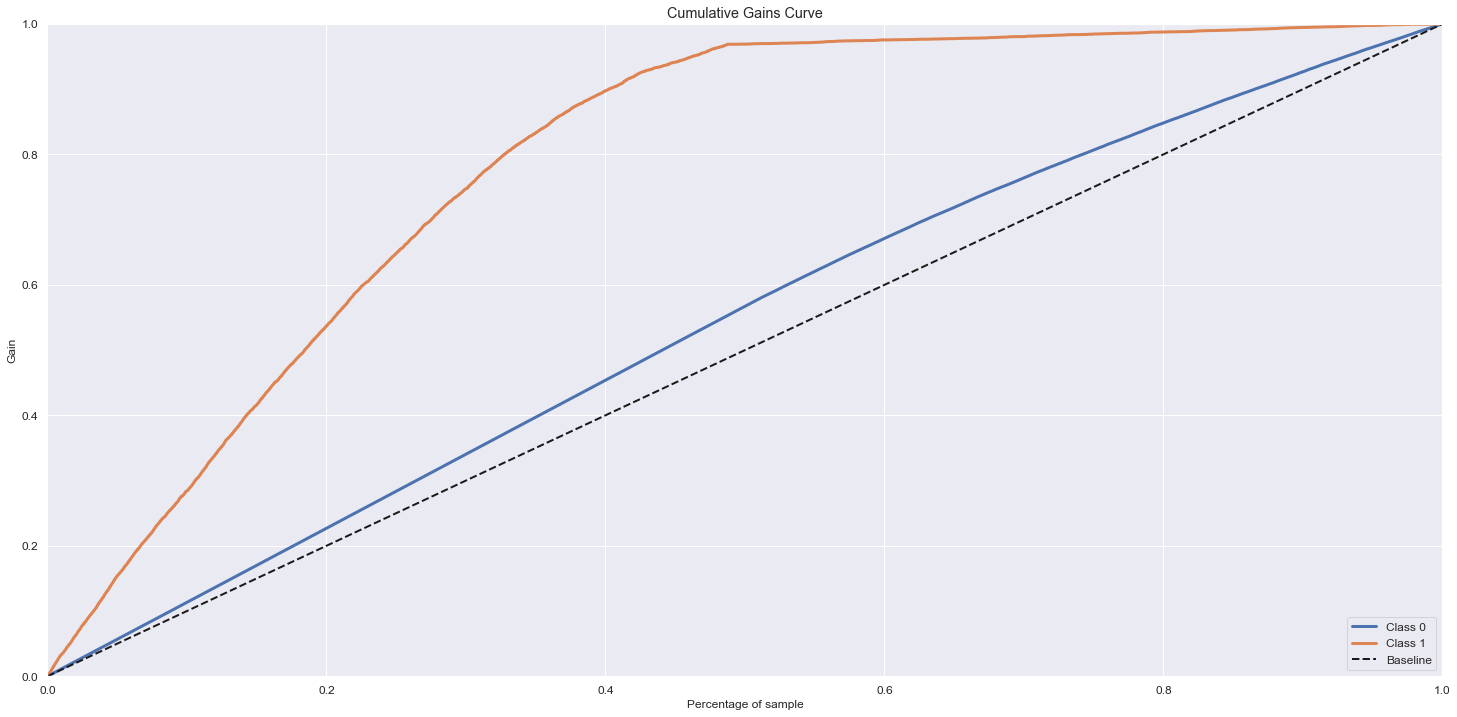

In [20]:
knn_model = KNeighborsClassifier(n_neighbors=30,
                                 n_jobs=-1).fit( x_train.values , y_train.values )

yhat_knn = knn_model.predict_proba( x_test.values )

skplt.metrics.plot_cumulative_gain(y_test, yhat_knn)

## 8.2 Random Forest

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

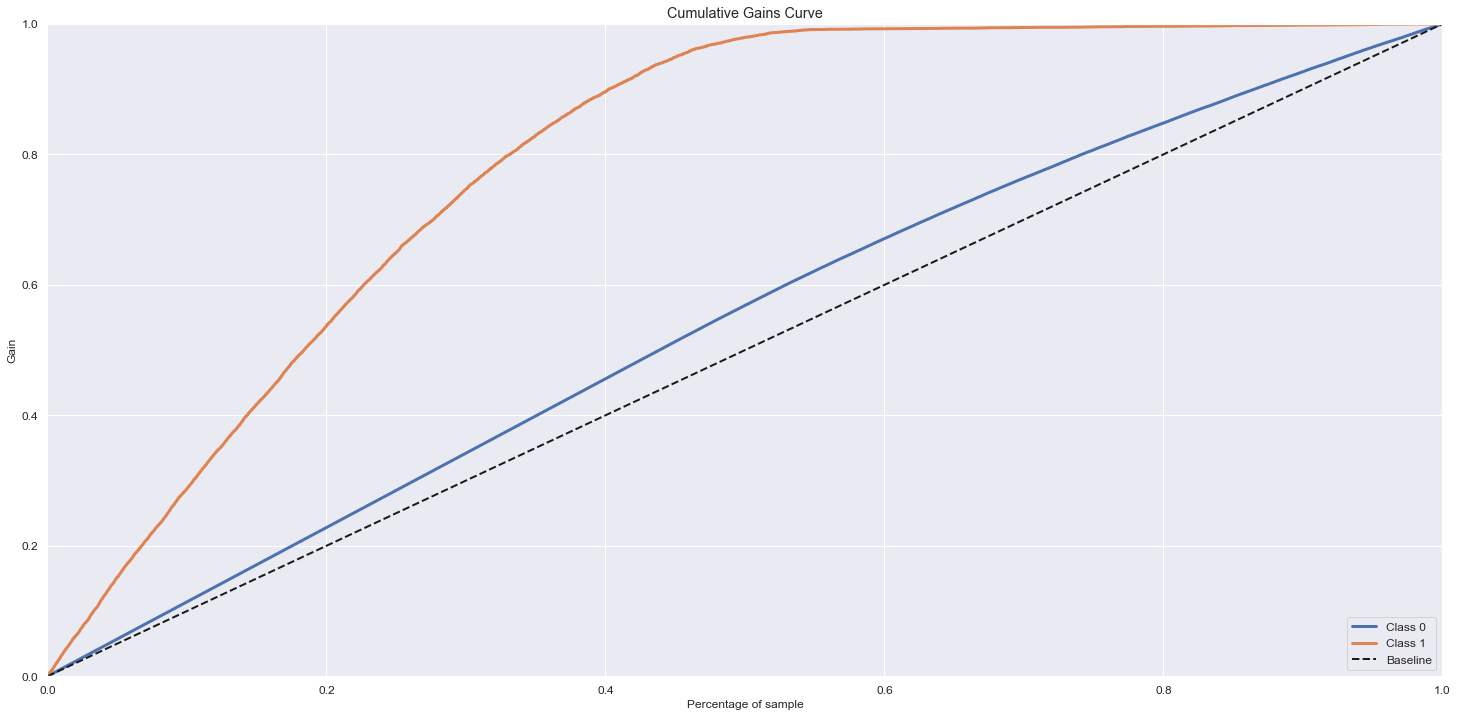

In [21]:
rf_model = en.RandomForestClassifier(n_estimators=300,
                                 n_jobs=-1,
                                 random_state=42 ).fit( x_train, y_train )

yhat_rf = rf_model.predict_proba(x_test)

skplt.metrics.plot_cumulative_gain(y_test, yhat_rf)

## 8.4 XGBoost

[13:28:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

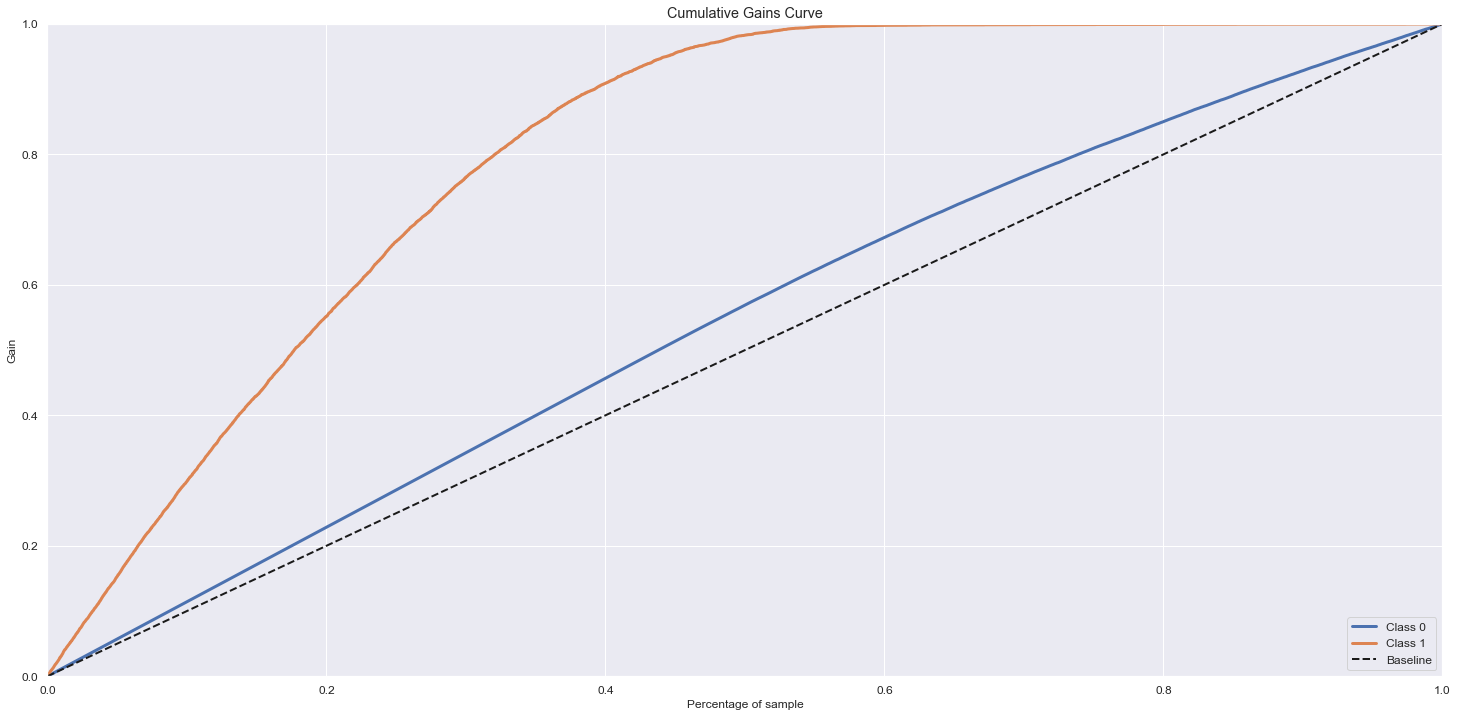

In [22]:
xgboost_model = XGBClassifier(learning_rate =0.1,
                             n_estimators=1000,
                             max_depth=10,
                             min_child_weight=1,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             nthread=4,
                             use_label_encoder=False,
                             seed=42).fit(x_train, y_train)

yhat_xgb = xgboost_model.predict_proba(x_test)

skplt.metrics.plot_cumulative_gain(y_test, yhat_xgb)

## 8.5 Logistic Regression

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

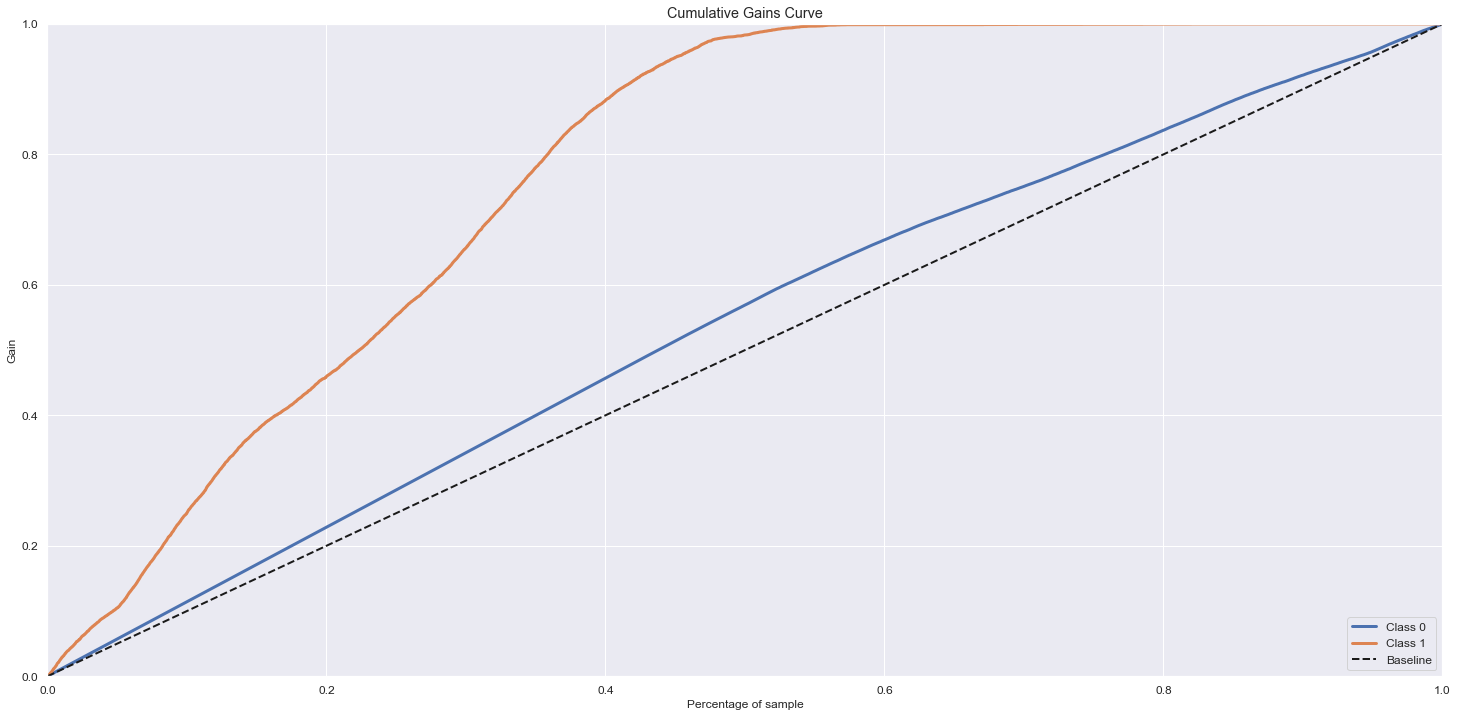

In [23]:
lr_model = lm.LogisticRegression(random_state=42).fit(x_train, y_train)

yhat_lr = lr_model.predict_proba(x_test)

skplt.metrics.plot_cumulative_gain(y_test, yhat_lr)

## 8.6 Gaussian Naive-Bayes

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

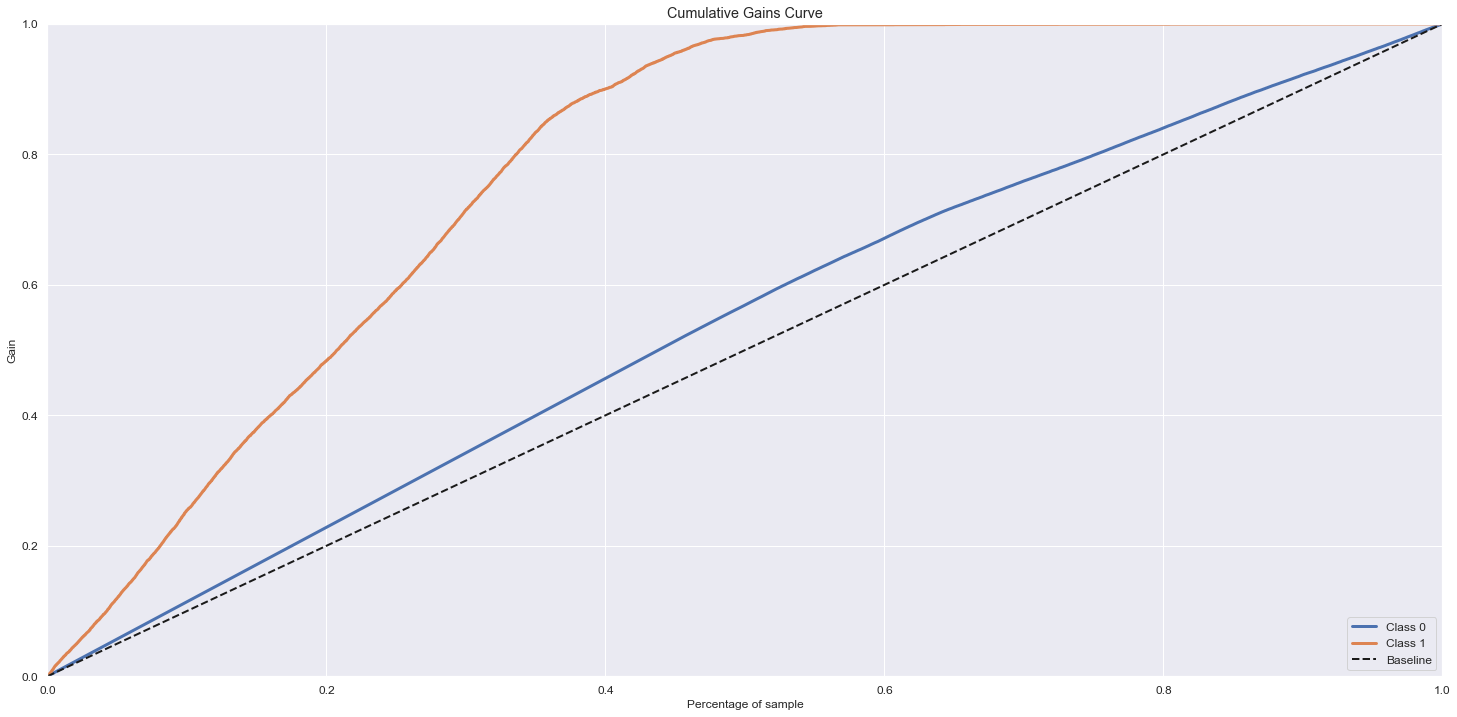

In [24]:
gnb_model = GaussianNB().fit(x_train, y_train)

yhat_gnb = gnb_model.predict_proba(x_test)

skplt.metrics.plot_cumulative_gain(y_test, yhat_gnb)

## 8.7 Adaboost

/home/rafael/Downloads/portfolio/Cross-Sell/.cross-sell/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

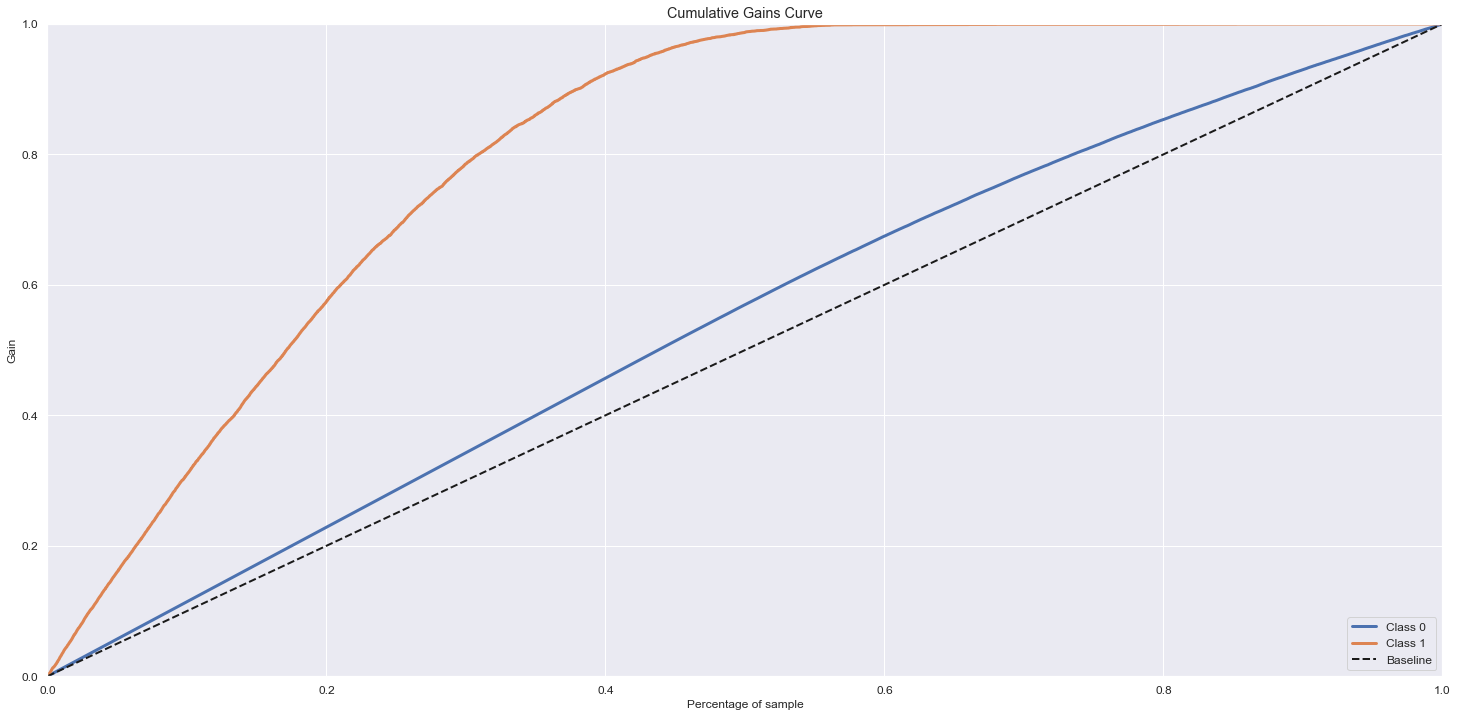

In [25]:
adab_model = en.AdaBoostClassifier(n_estimators=1000,
                                   random_state=42).fit(x_train, y_train)

yhat_adab = adab_model.predict_proba(x_test)

skplt.metrics.plot_cumulative_gain(y_test, yhat_adab)

## 8.8 LGBM

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

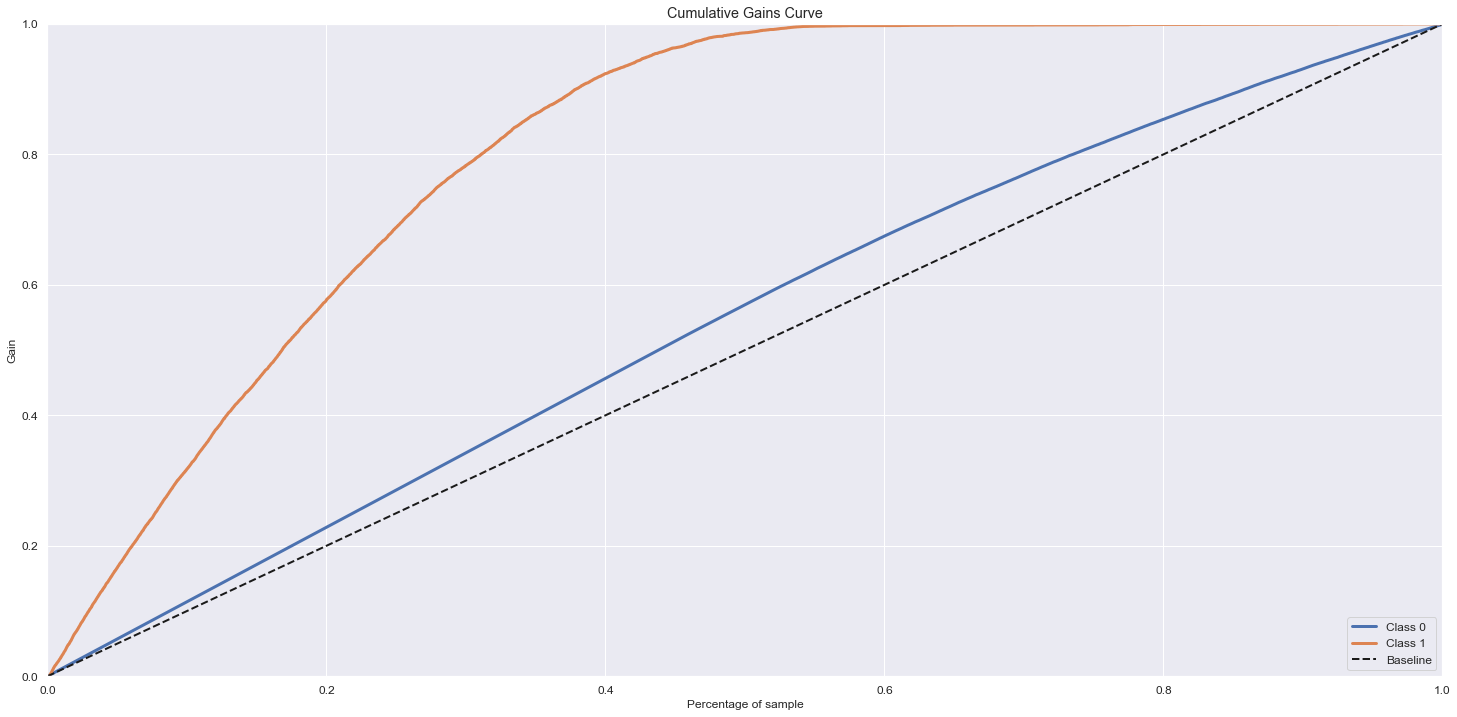

In [26]:
lgbm_model = lgb.LGBMClassifier(n_estimators=1000,
                                n_jobs = -1,
                                max_depth=30,
                                random_state=42).fit(x_train, y_train)

yhat_lgbm = lgbm_model.predict_proba(x_test)

skplt.metrics.plot_cumulative_gain(y_test, yhat_lgbm)

## 8.6 Compare Model's Performance

### 8.6.1 Single Run Performance

In [27]:
#Metrics: Precision at k and recall at k
#Precision at k: percentage of recommendation at k that are positive
#recall at k:    percentage of total positive responses at k

ls_preds = [yhat_knn, yhat_rf, yhat_xgb, yhat_lr, yhat_gnb, yhat_adab, yhat_lgbm]

performances = { 'model':['KNN', 'Random Forest', 'XGBooost', 'Logistic Regression', 'GaussianNB', 'Adaboost', 'LGBM'],
                 'recall':[recall_at_k(x_test, y_test, pred, k=20000) for pred in ls_preds],
                 'precision':[precision_at_k(x_test, y_test, pred, k=20000) for pred in ls_preds]}

pd.DataFrame(performances)

,model,recall,precision
0,KNN,0.68,0.32
1,Random Forest,0.68,0.32
2,XGBooost,0.69,0.33
3,Logistic Regression,0.58,0.27
4,GaussianNB,0.62,0.30
5,Adaboost,0.71,0.34
6,LGBM,0.71,0.34


## 8.6.2 Cross Validation

In [28]:
knn_model = KNeighborsClassifier(n_neighbors=30,
                                 n_jobs=-1)

rf_model  = en.RandomForestClassifier(n_estimators=300,
                                      n_jobs=-1,
                                      random_state=42 )

xgboost_model = XGBClassifier(learning_rate =0.1,
                             n_estimators=1000,
                             max_depth=10,
                             min_child_weight=1,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             eval_metric='logloss',
                             nthread=4,
                             use_label_encoder=False,
                             seed=42)

lr_model = lm.LogisticRegression(random_state=42)

gnb_model = GaussianNB()

adab_model = en.AdaBoostClassifier(n_estimators=1000,
                                   random_state=42)

lgbm_model = lgb.LGBMClassifier(n_estimators=1000,
                                n_jobs = -1,
                                max_depth=30,
                                random_state=42)

knn_cv = cross_validation(x_train, y_train, knn_model, 'K Nearest Neighbors')
rf_cv = cross_validation(x_train, y_train, rf_model, 'Random Forest')
xgb_cv = cross_validation(x_train, y_train, xgboost_model, 'XGBoost')
lr_cv = cross_validation(x_train, y_train, lr_model, 'Logistic Regression')
gnb_cv = cross_validation(x_train, y_train, gnb_model, 'GaussianNB')
adab_cv = cross_validation(x_train, y_train, adab_model, 'Adaboost')
lgbm_cv = cross_validation(x_train, y_train, lgbm_model, 'LightGBM')

K Nearest Neighbors: 1/5
K Nearest Neighbors: 2/5
K Nearest Neighbors: 3/5
K Nearest Neighbors: 4/5
K Nearest Neighbors: 5/5
Random Forest: 1/5
Random Forest: 2/5
Random Forest: 3/5
Random Forest: 4/5
Random Forest: 5/5
XGBoost: 1/5
XGBoost: 2/5
XGBoost: 3/5
XGBoost: 4/5
XGBoost: 5/5
Logistic Regression: 1/5
Logistic Regression: 2/5
Logistic Regression: 3/5
Logistic Regression: 4/5
Logistic Regression: 5/5
GaussianNB: 1/5
GaussianNB: 2/5
GaussianNB: 3/5
GaussianNB: 4/5
GaussianNB: 5/5
Adaboost: 1/5
Adaboost: 2/5
Adaboost: 3/5
Adaboost: 4/5
Adaboost: 5/5
LightGBM: 1/5
LightGBM: 2/5
LightGBM: 3/5
LightGBM: 4/5
LightGBM: 5/5


In [29]:
pd.concat([knn_cv, rf_cv, xgb_cv, lr_cv, gnb_cv, adab_cv, lgbm_cv], axis=0).reset_index(drop=True)

,model_name,recall_at_k,precision_at_k
0,K Nearest Neighbors,0.7904 +/- 0.0044,0.2417 +/- 0.0013
1,Random Forest,0.7957 +/- 0.0045,0.2433 +/- 0.0014
2,XGBoost,0.8046 +/- 0.0058,0.2460 +/- 0.0018
3,Logistic Regression,0.6669 +/- 0.0080,0.2039 +/- 0.0024
4,GaussianNB,0.7375 +/- 0.0103,0.2255 +/- 0.0031
5,Adaboost,0.8244 +/- 0.0073,0.2521 +/- 0.0022
6,LightGBM,0.8203 +/- 0.0064,0.2508 +/- 0.0020


# 9 HYPERPARAMETER FINE TUNING

## 9.1 Random Search

In [ ]:
max_eval=15

hp_result=pd.DataFrame()

param = {'n_estimators': [300, 500, 1000, 1500, 2000],
         'learning_rate': [0.1, 0.5, 1, 1.5],
         'algorithm': ['SAMME', 'SAMME.R']
         }

final_result = pd.DataFrame()

for i in range( max_eval ):
    # choose values for parameters randomly
    hp = { k: random.choice( v ) for k, v in param.items() }
    print( f'RS Step {i+1}:', hp )

    # model
    adab_model = en.AdaBoostClassifier(n_estimators=hp['n_estimators'],
                                       learning_rate=hp['learning_rate'],
                                       algorithm=hp['algorithm'],
                                       random_state=42)
    # performance
    result = cross_validation(x_train, y_train, adab_model, 'Adaboost')
    final_result = pd.concat( [final_result, result] )

final_result

## 9.2 Final Model

In [30]:
cols_selected = ['vintage',
                 'annual_premium',
                 'age',
                 'region_code',
                 'vehicle_damage',
                 'policy_sales_channel',
                 'previously_insured',
                 'response']

df_final_model = df6[cols_selected].copy()

In [31]:
#dump the scalers
annual_premium_scaler = RobustScaler().fit( df_final_model[['annual_premium']] )
pickle.dump(annual_premium_scaler,open('annual_premium_scaler.pkl', 'wb'))

vintage_scaler = MinMaxScaler().fit( df_final_model[['vintage']] )
pickle.dump(vintage_scaler,open('vintage_scaler.pkl', 'wb'))

age_scaler = MinMaxScaler().fit( df_final_model[['age']] )
pickle.dump(age_scaler,open('age_scaler.pkl', 'wb'))

region_code_encoder = freq_encoder()
region_code_encoder.fit(  df_final_model[['region_code']] )
pickle.dump(region_code_encoder,open('region_code_encoder.pkl', 'wb'))

sales_channel_encoder = freq_encoder()
sales_channel_encoder.fit(  df_final_model[['policy_sales_channel']] )
pickle.dump(sales_channel_encoder,open('sales_channel_encoder.pkl', 'wb'))

In [32]:
df_final_model['vintage'] =               vintage_scaler.transform( df_final_model[['vintage']] )
df_final_model['annual_premium']  =       annual_premium_scaler.transform(df_final_model[['annual_premium']])
df_final_model['age'] =                   age_scaler.transform( df_final_model[['age']] )
df_final_model['region_code']  =          region_code_encoder.transform(df_final_model[['region_code']])
df_final_model['policy_sales_channel']  = sales_channel_encoder.transform(df_final_model[['policy_sales_channel']])
df_final_model['vehicle_damage'] =        df_final_model[['vehicle_damage']].apply(lambda x: 1 if x['vehicle_damage'] == 'Yes' else 0, axis=1)

df_final_model = df_final_model.reset_index(drop=True)

x_final_model = df_final_model.drop('response', axis=1).copy()
y_final_model = df_final_model[['response']].copy()

x_balanced_final, y_balanced_final = SMOTETomek(sampling_strategy='not minority',
                                    random_state=42,
                                    n_jobs=-1
                                    ).fit_resample(x_final_model, y_final_model)

final_model = en.AdaBoostClassifier(n_estimators=1000,
                                    learning_rate=1.0,
                                    algorithm= 'SAMME.R',
                                    random_state=42).fit(x_balanced_final.values, y_balanced_final.values)

with open('model_adaboost_trained.pkl','wb') as model_file:
    pickle.dump( final_model, model_file)

/home/rafael/Downloads/portfolio/Cross-Sell/.cross-sell/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 10 Performance Report

## 10.1 Business Performance

/home/rafael/Downloads/portfolio/Cross-Sell/.cross-sell/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


<Figure size 720x432 with 0 Axes>

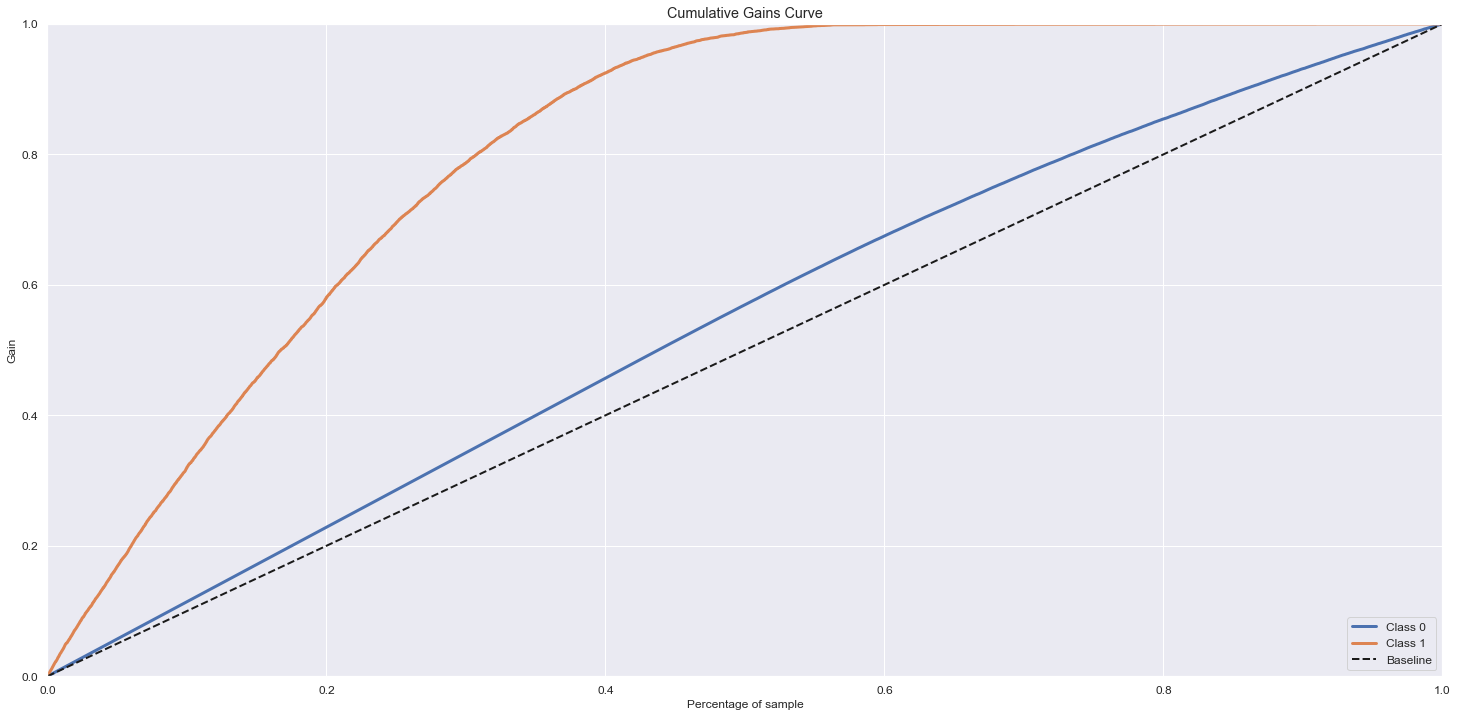

In [32]:
plt.figure(figsize=(10, 6))
skplt.metrics.plot_cumulative_gain(y_test,final_model.predict_proba(x_test));

/home/rafael/Downloads/portfolio/Cross-Sell/.cross-sell/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


<Figure size 720x432 with 0 Axes>

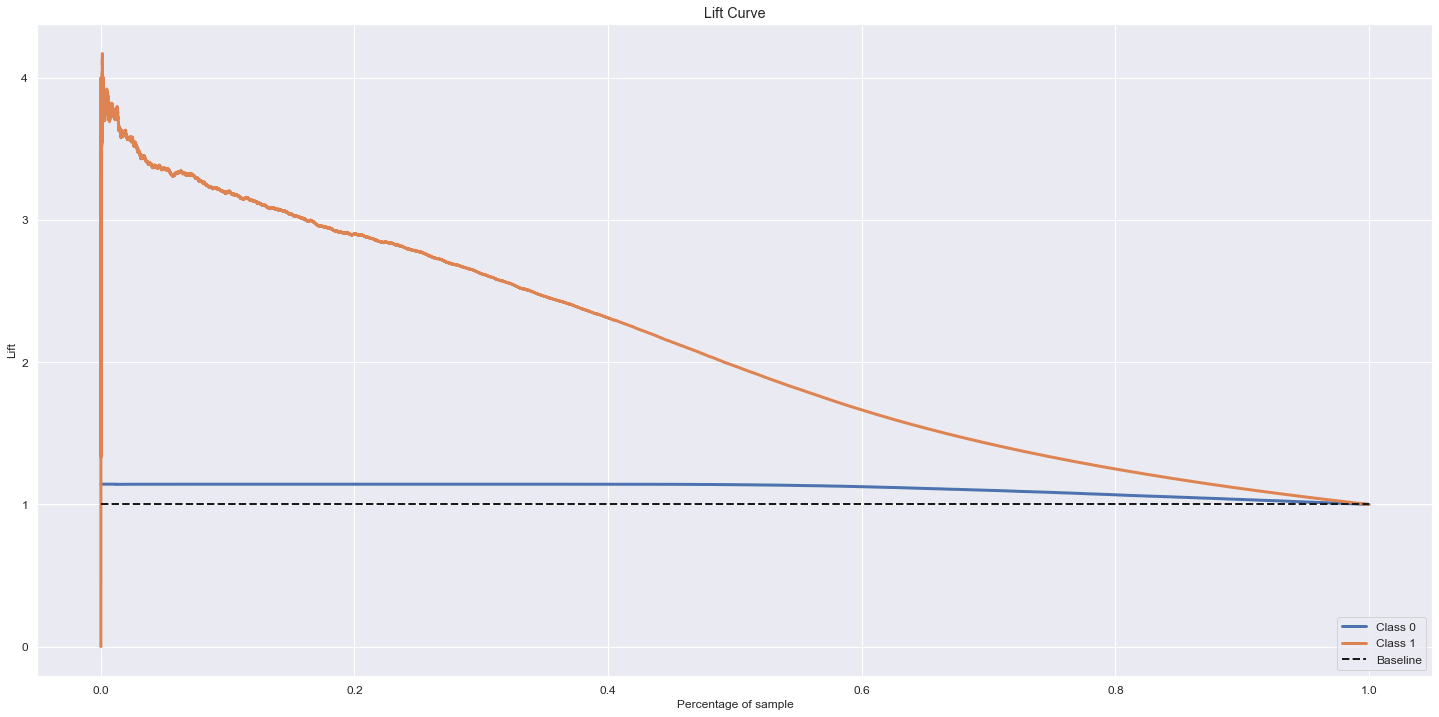

In [33]:
#How much better than random choice our algorithm is
plt.figure(figsize=(10, 6))
skplt.metrics.plot_lift_curve(y_test,final_model.predict_proba(x_test));

## 10.2 Construction of Class and Return over investment

In [90]:
class ClientRanker():
    def __init__(self):
        self.home_path             = os.getcwd()
        self.vintage_scaler        = pickle.load(open(os.path.join(self.home_path,'vintage_scaler.pkl'), 'rb'))
        self.annual_premium_scaler = pickle.load(open(os.path.join(self.home_path,'annual_premium_scaler.pkl'), 'rb'))
        self.age_scaler            = pickle.load(open(os.path.join(self.home_path,'age_scaler.pkl'), 'rb'))
        self.region_code_encoder   = pickle.load(open(os.path.join(self.home_path,'region_code_encoder.pkl'), 'rb'))
        self.sales_channel_encoder = pickle.load(open(os.path.join(self.home_path,'sales_channel_encoder.pkl'), 'rb'))
        self.model_adaboost        = pickle.load(open(os.path.join(self.home_path,'model_adaboost_trained.pkl'), 'rb'))
    
    def _set_columns_names(self, df):
        df.columns= df.columns.str.lower()
        return df
    
    def _rescale(self, df):
        df['vintage']         = self.vintage_scaler.transform( df[['vintage']] )
        df['annual_premium']  = self.annual_premium_scaler.transform(df[['annual_premium']])
        df['age']             = self.age_scaler.transform( df[['age']] )
        
        return df

    def _encode(self, df):
        df['vehicle_damage'] = df[['vehicle_damage']].apply(lambda x: 1 if x['vehicle_damage'] == 'Yes' else 0, axis=1)

        df['region_code']  = region_code_encoder.transform(df[['region_code']])

        df['policy_sales_channel']  = sales_channel_encoder.transform(df[['policy_sales_channel']])
        
        return df.dropna()
     
                                                 
    def _select_columns(self, df):
        return df[['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']]
    
    def _score_clients(self, df):
        clients_score = self.model_adaboost.predict_proba(df)
        df['score']   = clients_score[:,1]
        return df
        
    def _rescale_score(self, df):
        df['score']   = df[['score']].apply(lambda x: np.exp(10*x['score']), axis=1)
        return df
    
    def predict(self, df):
        df = self._set_columns_names(df)
        df = self._select_columns(df)
        df_raw = df.copy()
        df = self._rescale(df)
        df = self._encode(df)
        df = self._score_clients(df)
        df = self._rescale_score(df)
        
        df_response = pd.concat([df_raw, df[['score']]], axis=1)
        
        return df_response

/home/rafael/Downloads/portfolio/Cross-Sell/.cross-sell/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


<AxesSubplot:ylabel='return_over_investment'>

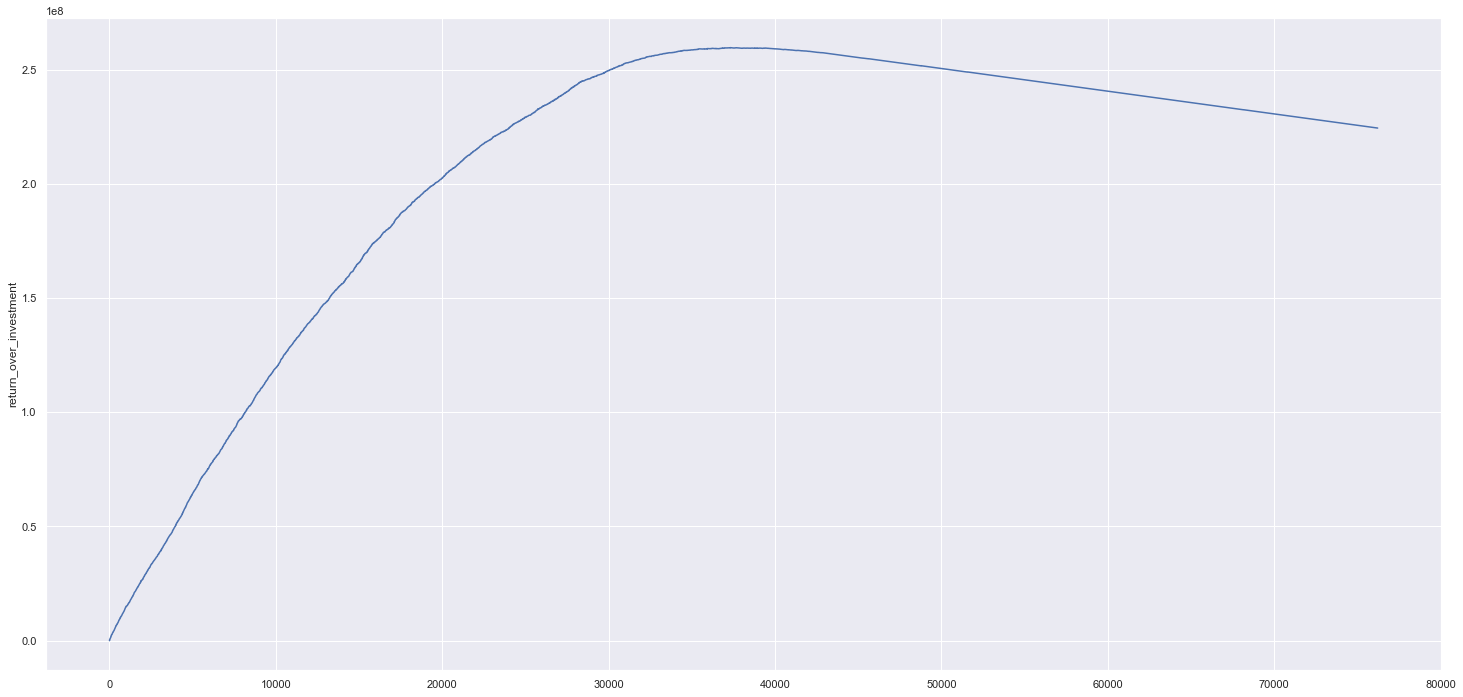

In [104]:
#Return over investment
# Since I don't have access to this kind of information, I will suppose that the contact with each customer
# on the list will costs $1000 on average.

_, x_test_2, _, y_test_2 = ms.train_test_split(X, y, test_size=0.2, random_state=42)

ranker = ClientRanker()
ranked_clients = ranker.predict( x_test_2 )
ranked_clients = pd.concat([ranked_clients, y_test_2], axis=1).sort_values(by='score', ascending=False)
ranked_clients['return_over_investment_per_client'] = ranked_clients[['annual_premium', 'response']].apply(lambda x: x['annual_premium']*x['response'] - 1000, axis=1)
ranked_clients['return_over_investment'] = ranked_clients['return_over_investment_per_client'].cumsum()

aux1 = ranked_clients.reset_index(drop=True)
sns.lineplot(x=aux1.index, y=aux1['return_over_investment'])

From the above graph we can see that tha maximum profit would be 37314 (49%) customers contacted with a return of $259,612,358.00